In [1117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, interp1d
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
from matplotlib.lines import Line2D

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, RealData
from scipy.stats import pearsonr
from scipy.integrate import quad

## Hysteresekurve von Permenorm 5000 H2

In [1118]:
file_path = '/Users/danielmiksch/Downloads/M1.csv'
data_m1 = pd.read_csv(file_path, sep=';')
#print(data_m9)

In [1119]:
def H(U):
    return (N1 * U) / (np.pi * d * R)

def B(U):
    return (2  * gamma * U) / (N2 * (d_a - d_i) * h * F)

In [1120]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m1.to_numpy()
data_np

array([[ 0.   , -6.689, -0.005],
       [ 0.02 , -6.689, -0.004],
       [ 0.04 , -6.689, -0.005],
       ...,
       [53.48 , -7.046, -0.006],
       [53.5  , -7.046, -0.006],
       [53.52 , -7.046, -0.007]])

In [1121]:
data_x = data_np[:,1]
data_y = data_np[:,2]

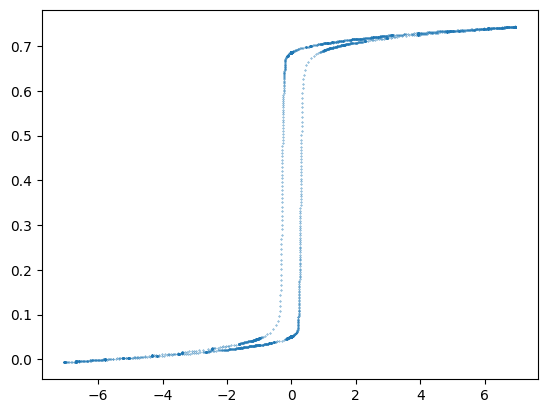

In [1122]:
fig, ax = plt.subplots(dpi=100)
plt.scatter(data_x, data_y, s=0.1)

In [1123]:
N1, N2 = 605, 80
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = 67.6 #[Ohm]
gamma= 0.1
F = 0.9
h = 0.03 #[m]
D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
data_korr = data_np.copy()
data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2
delta_U

0.36999962630792227

In [1124]:
d_Flux = ufloat(0, (100 / 1000) * 0.025)
d_Inter = ufloat(0, 0.00122)
d_U = unumpy.std_devs(d_Inter + d_Flux) #[V]
N1, N2 = 605, 80
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R_u = ufloat(67.6, 0.1) #[Ohm]
gamma= 0.1
F = 0.9
h = 0.03 #[m]

data_col1 = data_np[:, 1].copy()
data_col2 = data_np[:, 2].copy()

udata1 = unumpy.uarray(data_col1, d_U)
udata2 = unumpy.uarray(data_col2, d_U)
data_unp = np.column_stack((data_np[:,0], udata1, udata2))
# D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
# data_korr = data_np.copy()
# data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
# delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2

D_drift = (data_unp[-1, 2] - data_unp[0, 2]) / (data_unp[-1, 0] - data_unp[0, 0])
data_ukorr = data_unp.copy()
data_ukorr[:,2] = data_unp[:,2] - (data_unp[:,0] * D_drift)
delta_U = np.max(data_ukorr[:,2]) - (np.max(data_ukorr[:,2]) - np.min(data_ukorr[:,2])) / 2

In [1125]:
data_usymm = data_ukorr.copy()
data_usymm[:,2] -= delta_U

In [1126]:
data_utrans = data_usymm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_utrans[:,1] = vec_H(data_utrans[:,1])
data_utrans[:,2] = vec_B(data_utrans[:,2])
data_utrans

array([[0.0, -79.39785326389563+/-0.03301970216833264,
        -0.8680546905275976+/-0.006829392091373718],
       [0.02, -79.39785326389563+/-0.03301970216833264,
        -0.8657381456568676+/-0.010429593794115037],
       [0.04, -79.39785326389563+/-0.03301970216833264,
        -0.8680512304157668+/-0.010427367232069997],
       ...,
       [53.48, -83.63541248279392+/-0.03301970216833264,
        -0.8657433358246137+/-0.008207174928539783],
       [53.5, -83.63541248279392+/-0.03301970216833264,
        -0.8657416057686983+/-0.008208117467462668],
       [53.52, -83.63541248279392+/-0.03301970216833264,
        -0.8680546905275976+/-0.006829392091373718]], dtype=object)

In [1127]:
x_udata = data_utrans[:,1]
y_udata = data_utrans[:,2]

In [1128]:
half_hyst = np.argmax(x_udata)

In [1129]:
nominal_values = unumpy.nominal_values(data_utrans)
std_devs = unumpy.std_devs(data_utrans)
data_trans = np.column_stack((nominal_values, std_devs[:,1:]))

In [1130]:
data_interp = data_trans[half_hyst:]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data1 = data_interp[unique_indices]
f_cubic1_best = interp1d(filtered_data1[:,1], filtered_data1[:,2], kind='linear')
f_cubic1_max = interp1d(filtered_data1[:,1], filtered_data1[:,2] + filtered_data1[:,4], kind='linear')
x = np.linspace(-79, 80, 1000)
# plt.scatter(filtered_data[:,1], filtered_data[:,2], s=1)
# plt.plot(x, f_cubic(x))

In [1131]:
data_interp = data_trans[:half_hyst]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data2 = data_interp[unique_indices]
f_cubic2_best = interp1d(filtered_data2[:,1], filtered_data2[:,2], kind='linear')
f_cubic2_max = interp1d(filtered_data2[:,1], filtered_data2[:,2] - filtered_data2[:,4], kind='linear')
# plt.plot(x, f_cubic2_max(x))
# plt.plot(x, f_cubic1_max(x))

In [1132]:
data_symm = data_korr.copy()
data_symm[:,2] -= unumpy.nominal_values(delta_U)

In [1133]:
data_trans = data_symm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_trans[:,1] = vec_H(data_trans[:,1])
data_trans[:,2] = vec_B(data_trans[:,2])
data_trans

array([[  0.          , -79.3978532639,  -0.8680546905],
       [  0.02        , -79.3978532639,  -0.8657381457],
       [  0.04        , -79.3978532639,  -0.8680512304],
       ...,
       [ 53.48        , -83.6354124828,  -0.8657433358],
       [ 53.5         , -83.6354124828,  -0.8657416058],
       [ 53.52        , -83.6354124828,  -0.8680546905]])

In [1134]:
x_data = data_trans[:,1]
y_data = data_trans[:,2]
# plt.scatter(x_data, y_data, s=1)

In [1135]:
half_hyst = np.argmax(x_data)
half_hyst

1355

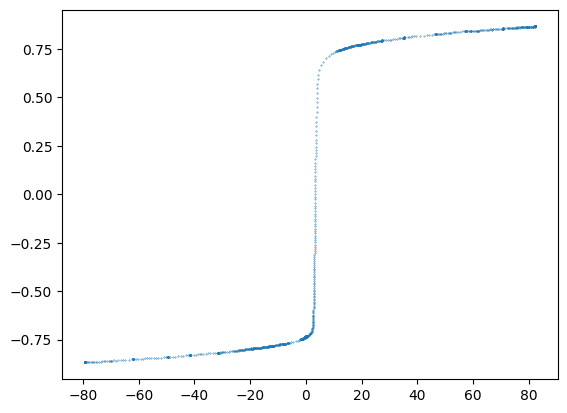

In [1136]:
x_test = x_data[:half_hyst]
y_test = y_data[:half_hyst]

x_test1 = x_data[4580:]
y_test1 = y_data[4580:]
plt.scatter(x_test, y_test, s=0.1)

In [1137]:
# @widgets.interact(start=(0, len(x_data)-100), end=(100, len(x_data)))
# def plot_subset(start=0, end=100):
#     plt.scatter(x_data[start:end], y_data[start:end], s=1)
#     plt.xlim(-60, 60)
#     plt.ylim(-1.4, 1.4)
#     plt.show()

### Anpassung bei H=0

In [1138]:
from scipy.optimize import curve_fit

In [1139]:
def model_f(x, b, a):
    return b * x + a

In [1140]:
data_trans_upper = data_trans[half_hyst:]
indices_upper = np.where((data_trans_upper[:,1]>-0.2) * (data_trans_upper[:,1]<0.2))[0]
lower_index_upper = indices_upper[[0, -1]][0]
upper_index_upper = indices_upper[[0, -1]][1]

data_fit_upper = data_trans_upper[lower_index_upper:upper_index_upper]
x_fit_upper = data_fit_upper[:,1]
y_fit_upper = data_fit_upper[:,2]

popt_upper, pcov_upper = curve_fit(model_f, x_fit_upper, y_fit_upper, p0=[0, 0])

b_opt_upper, a_opt_upper = popt_upper

popt_upper

array([0.0050298106, 0.7345895823])

array([ 0.0073734991, -0.7354840221])

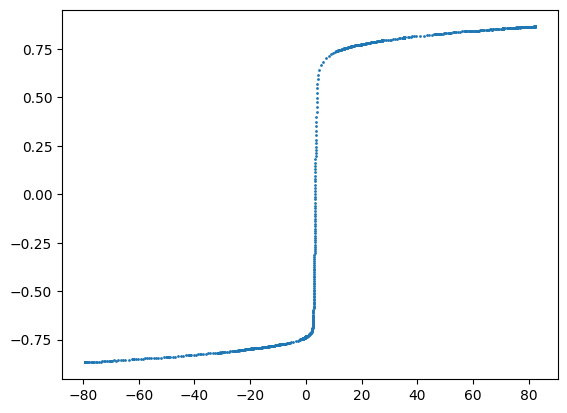

In [1141]:
data_trans_lower = data_trans[:half_hyst]

plt.scatter(data_trans_lower[:,1], data_trans_lower[:,2], s=1)

indices_lower = np.where((data_trans_lower[:,1]>-0.2) * (data_trans_lower[:,1]<0.2))[0]
lower_index_lower = indices_lower[[0, -1]][0]
upper_index_lower = indices_lower[[0, -1]][1]
data_fit_lower = data_trans_lower[lower_index_lower:upper_index_lower]
data_fit_lower
x_fit_lower = data_fit_lower[:,1]
y_fit_lower = data_fit_lower[:,2]

popt_lower, pcov_lower = curve_fit(model_f, x_fit_lower, y_fit_lower, p0=[0, 0])

b_opt_lower, a_opt_lower = popt_lower

popt_lower

### Anpassung der Flanken

In [1142]:
#y_test= data_trans[:,2][(data_trans[:,2]>-0.75) * (data_trans[:,2]<0.75)]
data_trans_segment1 = data_trans[half_hyst:]
indices_left = np.where((data_trans_segment1[:,2]>-0.4) * (data_trans_segment1[:,2]<0.4))[0]
lower_index_left = indices_left[[0, -1]][0]
upper_index_left = indices_left[[0, -1]][1]
data_fit1 = data_trans_segment1[lower_index_left:upper_index_left]
x_data_fit1 = data_fit1[:,1]
y_data_fit1 = data_fit1[:,2]
print(lower_index_left)
print(upper_index_left)
#plt.scatter(x_data_fit1, y_data_fit1, s=0.1)

891
929


In [1143]:
data_trans_segment2 = data_trans[:half_hyst]
indices_right = np.where((data_trans_segment2[:,2]>-0.4) * (data_trans_segment2[:,2]<0.4))[0]
lower_index_right = indices_right[[0, -1]][0]
upper_index_right = indices_right[[0, -1]][1]
data_fit2 = data_trans_segment2[lower_index_right:upper_index_right]
x_data_fit2 = data_fit2[:,1]
y_data_fit2 = data_fit2[:,2]

#plt.xlim(-80, 80)
#plt.ylim(-1.5, 1.5)
#plt.scatter(x_data_fit2, y_data_fit2, s=1)
#plt.scatter(data_trans_segment2[:,1], data_trans_segment2[:,2])

In [1144]:
popt, pcov = curve_fit(model_f, x_data_fit1, y_data_fit1, p0=[0, 0])
popt_H, pcov_H = curve_fit(model_f, x_data_fit2, y_data_fit2, p0=[0, 0])

In [1145]:
popt

array([1.2082356307, 4.2134113019])

In [1146]:
popt_H

array([ 1.1401126872, -3.8553754704])

In [1147]:
b_opt, a_opt = popt
x_model = np.linspace(min(x_test), max(x_test), 100)
#y_model = model_f(x_model, b_opt, a_opt)

In [1148]:
b_opt_right, a_opt_right = popt_H

In [1149]:
all_plots = []

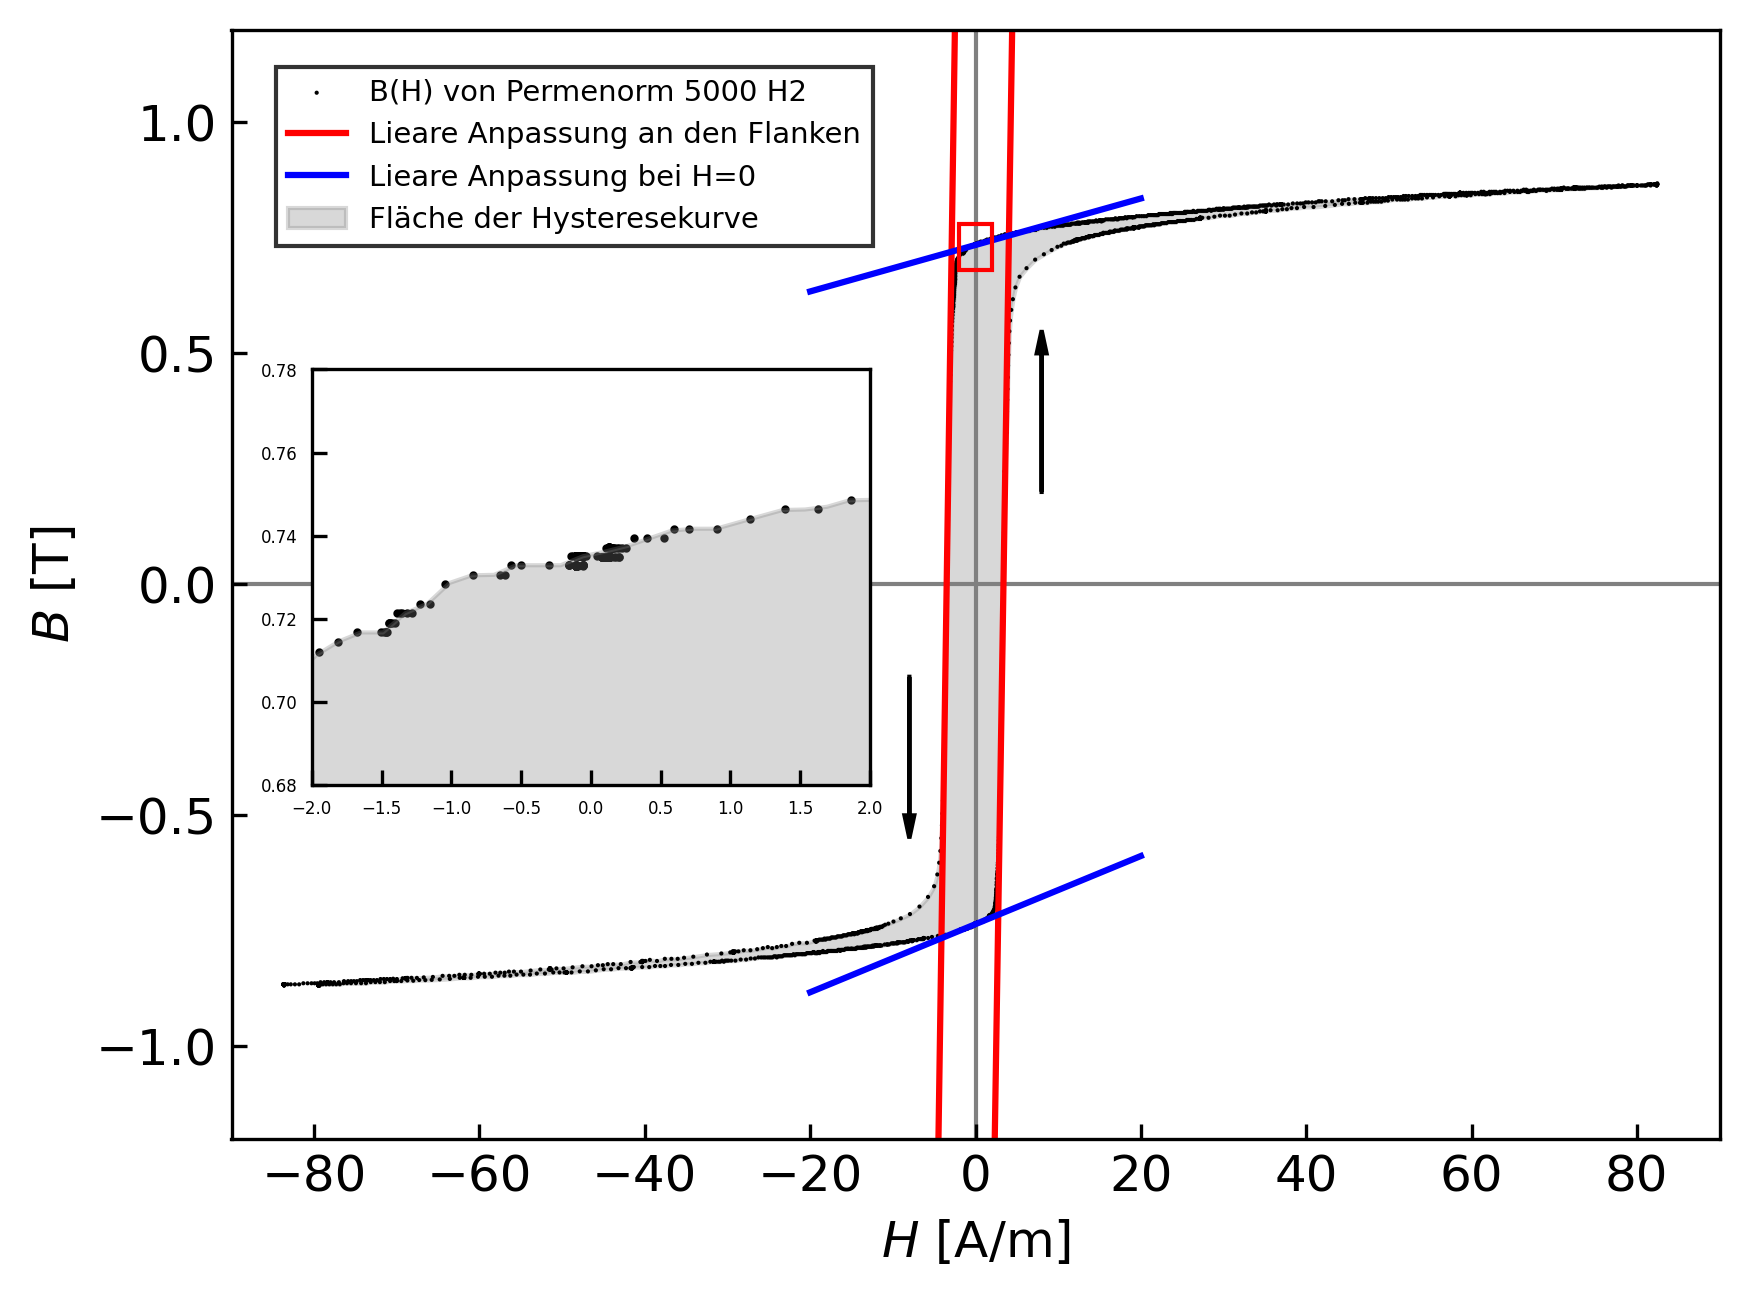

In [1150]:
plt1 = fig, ax = plt.subplots(dpi=300)

#Fit left
y1_left, y2_left = -1.4, 1.4
x1_left = (y1_left - a_opt) / b_opt
x2_left = (y2_left - a_opt) / b_opt
x_clipped_left = np.linspace(x1_left, x2_left, 400)
y_clipped_left = model_f(x_clipped_left, b_opt, a_opt)

#Fit right
y1_right, y2_right = -1.4, 1.4
x1_right = (y1_right - a_opt_right) / b_opt_right
x2_right = (y2_right - a_opt_right) / b_opt_right
x_clipped_right = np.linspace(x1_right, x2_right, 400)
y_clipped_right = model_f(x_clipped_right, b_opt_right, a_opt_right)

#Fit upper
x1_upper, x2_upper = -20, 20
y1_upper = b_opt_upper * x1_upper + a_opt_upper
y2_upper = b_opt_upper * x2_upper + a_opt_upper
x_clipped_upper = np.linspace(x1_upper, x2_upper, 400)
y_clipped_upper = model_f(x_clipped_upper, b_opt_upper, a_opt_upper)

#Fit lower
x1_lower, x2_lower = -20, 20
y1_lower = b_opt_lower * x1_lower + a_opt_lower
y2_lower = b_opt_lower * x2_lower + a_opt_lower
x_clipped_lower = np.linspace(x1_lower, x2_lower, 400)
y_clipped_lower = model_f(x_clipped_lower, b_opt_lower, a_opt_lower)

plt.scatter(x_data, y_data, marker='.', s=4, edgecolors='none', color='black', label='B(H) von Permenorm 5000 H2', zorder=2)
ax.set_xlim(-90, 90)
ax.set_ylim(-1.2, 1.2)
ax.set_ylabel('$B$ [T]', fontsize=12)
ax.set_xlabel('$H$ [A/m]', fontsize=12)

plt.plot(x_clipped_left, y_clipped_left, color='red', linewidth=1.5, label='Lieare Anpassung an den Flanken', zorder=2)
plt.plot(x_clipped_right, y_clipped_right, color='red', linewidth=1.5, zorder=2)
plt.plot(x_clipped_upper, y_clipped_upper, color='blue', linewidth=1.5, label='Lieare Anpassung bei H=0', zorder=2)
plt.plot(x_clipped_lower, y_clipped_lower, color='blue', linewidth=1.5, zorder=2)
plt.fill_between(x, f_cubic1_best(x), f_cubic2_best(x), color='gray', alpha=0.3, label='Fläche der Hysteresekurve')

#Arrows
ax.arrow(-8, -0.2, 0 , -0.3, head_width=1.2, head_length=0.05, fc='black', ec='black')
ax.arrow(8, 0.2, 0 , 0.3, head_width=1.2, head_length=0.05, fc='black', ec='black')


#plt.grid(linewidth=0.5, linestyle='--')
ax.axhline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
ax.axvline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)

axins = inset_axes(ax, 
                   width='75%', 
                   height='75%', 
                   bbox_to_anchor=(0.04, 0.3, 0.5, 0.5),
                   bbox_transform=ax.transAxes, 
                   loc='lower left')
x1, x2 = -2, 2
y1, y2 = 0.68, 0.78

axins.tick_params(axis='both', which='major', labelsize=4, direction='in')
axins.scatter(x_data, y_data, s=1, color='black')
axins.fill_between(x, f_cubic1_best(x), f_cubic2_best(x), color='gray', alpha=0.3)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="red", alpha=1)


plt.show()

all_plots.append(plt1)

## Hysteresekurve von Flachstahl ST37K

In [1151]:
file_path = '/Users/danielmiksch/Downloads/M6.csv'
data_m6 = pd.read_csv(file_path, sep=';')
#print(data_m9)

In [1152]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m6.to_numpy()
#data_np

### Symmetrisierung

In [1153]:
N1, N2 = 1010, 53
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = 0.2 #[Ohm]
gamma= 0.1
F = 1
h = 0.03 #[m]
D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
data_korr = data_np.copy()
data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2
delta_U

0.5057057569296375

In [1154]:
d_Flux = ufloat(0, (100 / 1000) * 0.025)
d_Inter = ufloat(0, 0.00122)
d_U = unumpy.std_devs(d_Inter + d_Flux) #[V]
N1, N2 = 1010, 53
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R_u = ufloat(0.2, 0.1) #[Ohm]
gamma= 0.1
F = 1
h = 0.03 #[m]

data_col1 = data_np[:, 1].copy()
data_col2 = data_np[:, 2].copy()

udata1 = unumpy.uarray(data_col1, d_U)
udata2 = unumpy.uarray(data_col2, d_U)
data_unp = np.column_stack((data_np[:,0], udata1, udata2))
# D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
# data_korr = data_np.copy()
# data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
# delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2

D_drift = (data_unp[-1, 2] - data_unp[0, 2]) / (data_unp[-1, 0] - data_unp[0, 0])
data_ukorr = data_unp.copy()
data_ukorr[:,2] = data_unp[:,2] - (data_unp[:,0] * D_drift)
delta_U = np.max(data_ukorr[:,2]) - (np.max(data_ukorr[:,2]) - np.min(data_ukorr[:,2])) / 2

In [1155]:
data_usymm = data_ukorr.copy()
data_usymm[:,2] -= delta_U

In [1156]:
data_utrans = data_usymm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_utrans[:,1] = vec_H(data_utrans[:,1]) / 1000
data_utrans[:,2] = vec_B(data_utrans[:,2])
data_utrans

array([[0.0, -6.751352685958201+/-0.018631844506157676,
        -1.5997036381435137+/-0.009110614018694537],
       [0.02, -6.751352685958201+/-0.018631844506157676,
        -1.5997022971396384+/-0.01381758654138946],
       [0.04, -6.751352685958201+/-0.018631844506157676,
        -1.5997009561357625+/-0.01381425561073031],
       ...,
       [46.86, -6.7647482270017685+/-0.018631844506157676,
        -1.599706320151265+/-0.011311932694584753],
       [46.88, -6.758050456479984+/-0.018631844506157676,
        -1.5965603250593388+/-0.011313626548116632],
       [46.9, -6.7647482270017685+/-0.018631844506157676,
        -1.5997036381435137+/-0.009110614018694537]], dtype=object)

In [1157]:
x_udata = data_utrans[:,1]
y_udata = data_utrans[:,2]

In [1158]:
half_hyst = np.argmax(x_udata)

In [1159]:
nominal_values = unumpy.nominal_values(data_utrans)
std_devs = unumpy.std_devs(data_utrans)
data_trans = np.column_stack((nominal_values, std_devs[:,1:]))

In [1160]:
data_interp = data_trans[half_hyst:]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data1 = data_interp[unique_indices]
f_cubic1_best = interp1d(filtered_data1[:,1] * 1000, filtered_data1[:,2], kind='linear')
f_cubic1_max = interp1d(filtered_data1[:,1] * 1000, filtered_data1[:,2] + filtered_data1[:,4], kind='linear')
x = np.linspace(-6758, 6704, 1000)
# plt.scatter(filtered_data1[:,1], filtered_data1[:,2], s=1)
# plt.plot(x, f_cubic(x))

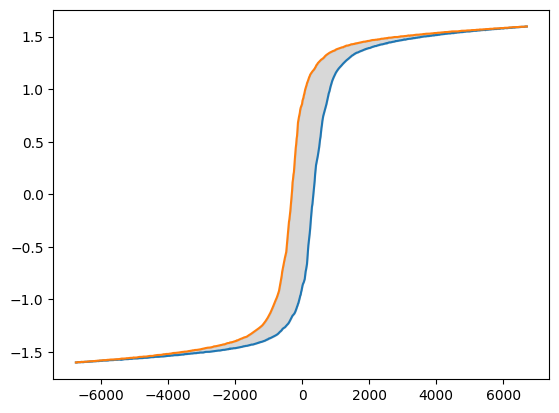

In [1161]:
data_interp = data_trans[:half_hyst]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data2 = data_interp[unique_indices]
f_cubic2_best = interp1d(filtered_data2[:,1] * 1000, filtered_data2[:,2], kind='linear')
f_cubic2_max = interp1d(filtered_data2[:,1] * 1000, filtered_data2[:,2] - filtered_data2[:,4], kind='linear')
plt.plot(x, f_cubic2_best(x))
plt.plot(x, f_cubic1_best(x))
plt.fill_between(x, f_cubic1_best(x), f_cubic2_best(x), color='gray', alpha=0.3)

In [1162]:
data_symm = data_korr.copy()
data_symm[:,2] -= unumpy.nominal_values(delta_U)

In [1163]:
data_trans = data_symm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_trans[:,1] = vec_H(data_trans[:,1]) / 1000 #in kA/m
data_trans[:,2] = vec_B(data_trans[:,2])

In [1164]:
x_data = data_trans[:,1]
y_data = data_trans[:,2]
#plt.plot(x_data, y_data)

In [1165]:
half_hyst = np.argmax(x_data)
half_hyst

1144

### Anspassug bei H=0 H (H in kA/m)

In [1166]:
data_trans_upper = data_trans[:half_hyst]
indices_upper = np.where((data_trans_upper[:,1]>-0.08) * (data_trans_upper[:,1]<0.08))[0]
lower_index_upper = indices_upper[[0, -1]][0]
upper_index_upper = indices_upper[[0, -1]][1]

data_fit_upper = data_trans[lower_index_upper:upper_index_upper]
x_fit_upper = data_fit_upper[:,1]
y_fit_upper = data_fit_upper[:,2]

popt_upper, pcov_upper = curve_fit(model_f, x_fit_upper, y_fit_upper, p0=[0, 0])

b_opt_upper, a_opt_upper = popt_upper

popt_upper

array([ 1.3628491033, -0.8766633948])

In [1167]:
data_trans_lower = data_trans[half_hyst:]
indices_lower = np.where((data_trans_lower[:,1]>-0.08) * (data_trans_lower[:,1]<0.08))[0]
lower_index_lower = indices_lower[[0, -1]][0]
upper_index_lower = indices_lower[[0, -1]][1]

data_fit_lower = data_trans_lower[lower_index_lower:upper_index_lower]
x_fit_lower = data_fit_lower[:,1]
y_fit_lower = data_fit_lower[:,2]

popt_lower, pcov_lower = curve_fit(model_f, x_fit_lower, y_fit_lower, p0=[0, 0])

b_opt_lower, a_opt_lower = popt_lower

popt_lower

array([1.3223973012, 0.8693945336])

### Anpassung der Flanken

In [1168]:
data_trans_segment1 = data_trans[:half_hyst]
indices_left = np.where((data_trans_segment1[:,2]>-0.3) * (data_trans_segment1[:,2]<0.3))[0]
indices_left[[0, -1]]
lower_index_left = indices_left[[0, -1]][0]
upper_index_left = indices_left[[0, -1]][1]
data_fit1 = data_trans_segment1[lower_index_left:upper_index_left]
x_data_fit1 = data_fit1[:,1]
y_data_fit1 = data_fit1[:,2]

popt, pcov = curve_fit(model_f, x_data_fit1, y_data_fit1, p0=[0, 0])
b_opt_left, a_opt_left = popt
popt

-a_opt_left / b_opt_left

0.327894636968879

In [1169]:
data_trans_segment2 = data_trans[half_hyst:]
indices_right = np.where((data_trans_segment2[:,2]>-0.3) * (data_trans_segment2[:,2]<0.3))[0]
lower_index_right = indices_right[[0, -1]][0]
upper_index_right = indices_right[[0, -1]][1]
data_fit2 = data_trans_segment2[lower_index_right:upper_index_right]
x_data_fit2 = data_fit2[:,1]
y_data_fit2 = data_fit2[:,2]

In [1170]:
popt_H, pcov_H = curve_fit(model_f, x_data_fit2, y_data_fit2, p0=[0, 0])

In [1171]:
b_opt_right, a_opt_right = popt_H
popt_H

-a_opt_right / b_opt_right

-0.3142221219223652

### Making Plot

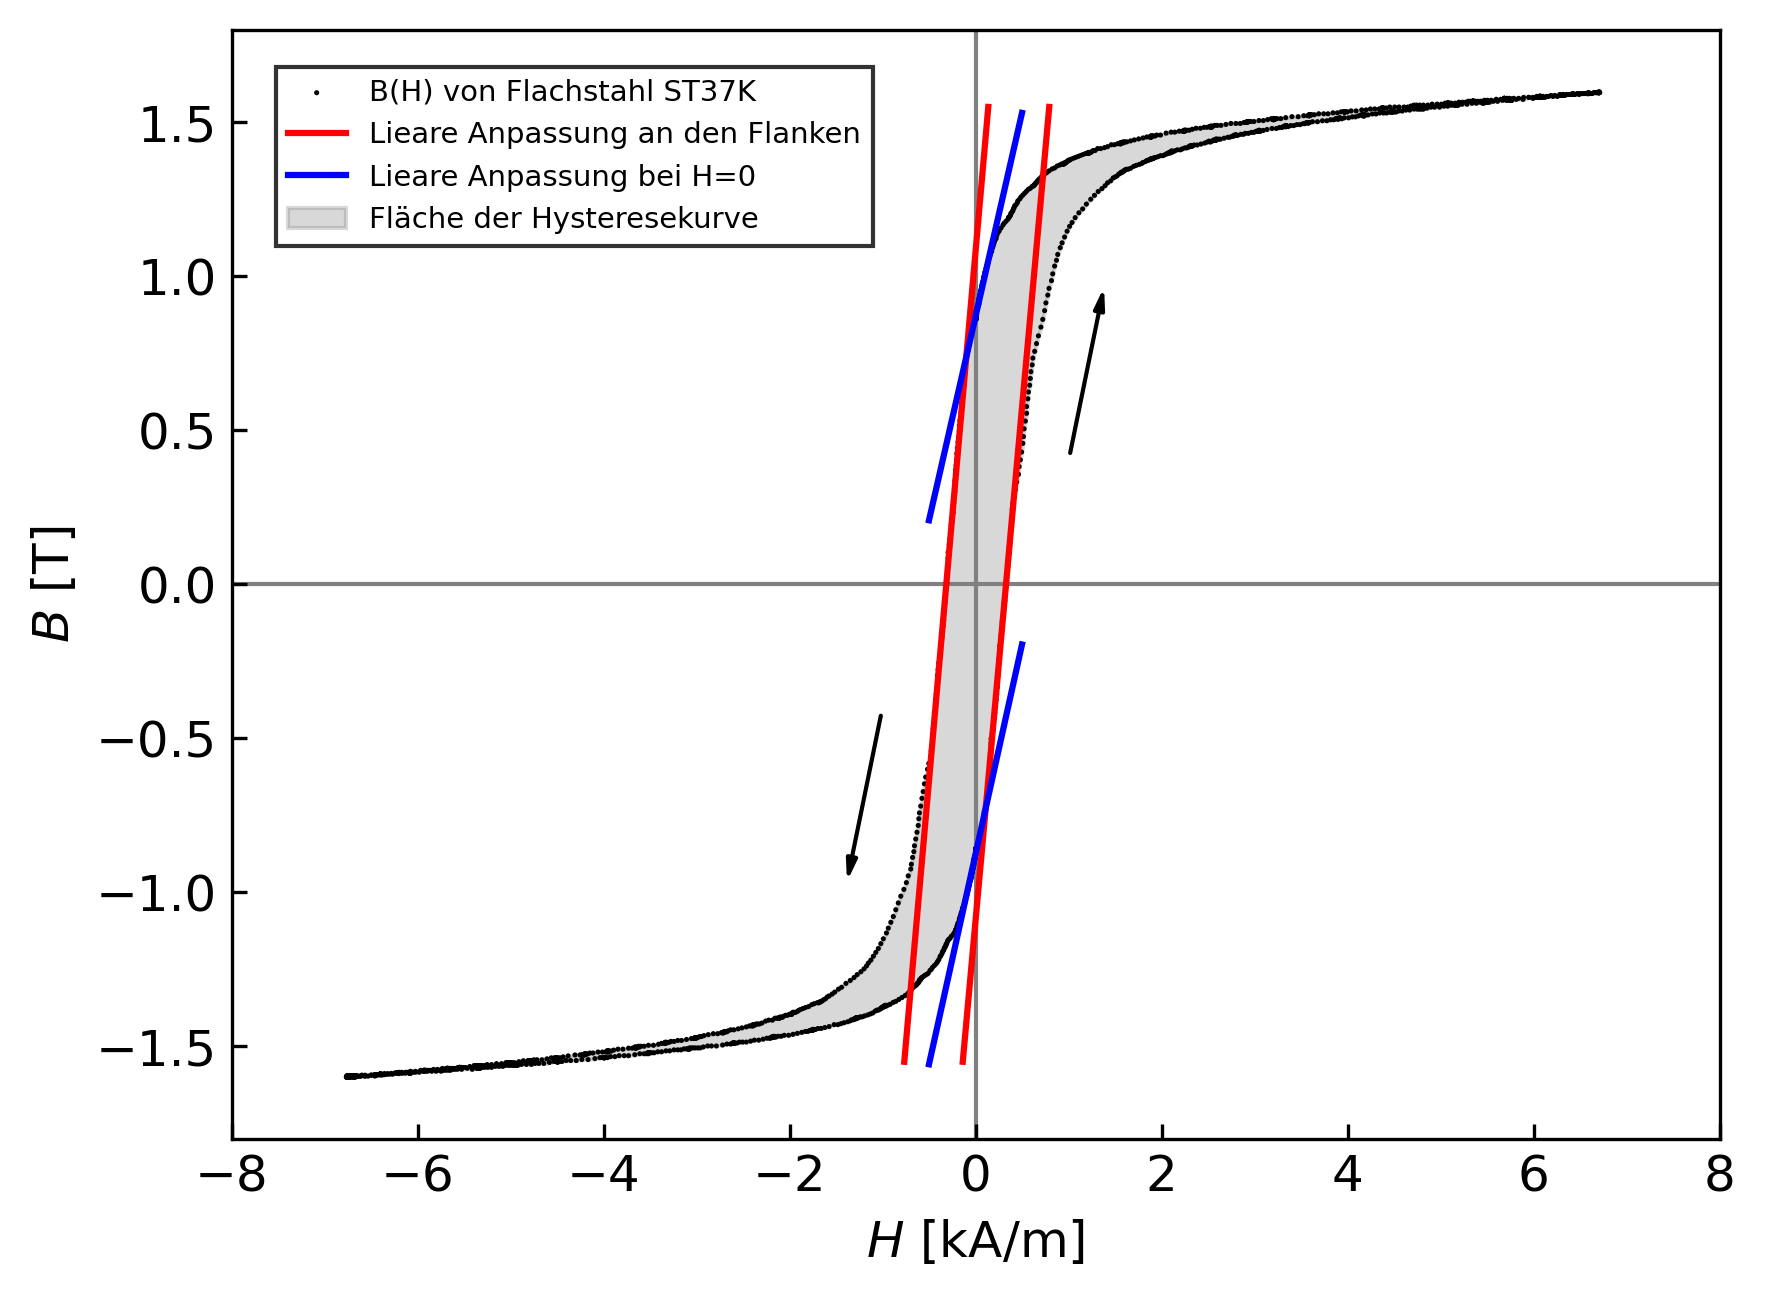

In [1172]:
plt2 = fig, ax = plt.subplots(dpi=300)

#Fit left
y1_left, y2_left = -1.55, 1.55
x1_left = (y1_left - a_opt_left) / b_opt_left
x2_left = (y2_left - a_opt_left) / b_opt_left
x_clipped_left = np.linspace(x1_left, x2_left, 400)
y_clipped_left = model_f(x_clipped_left, b_opt_left, a_opt_left)

x = np.linspace(-6758, 6704, 1000)

#Fit right
y1_right, y2_right = -1.55, 1.55
x1_right = (y1_right - a_opt_right) / b_opt_right
x2_right = (y2_right - a_opt_right) / b_opt_right
x_clipped_right = np.linspace(x1_right, x2_right, 400)
y_clipped_right = model_f(x_clipped_right, b_opt_right, a_opt_right)

#Fit upper
x1_upper, x2_upper = -0.5, 0.5
y1_upper = b_opt_upper * x1_upper + a_opt_upper
y2_upper = b_opt_upper * x2_upper + a_opt_upper
x_clipped_upper = np.linspace(x1_upper, x2_upper, 400)
y_clipped_upper = model_f(x_clipped_upper, b_opt_upper, a_opt_upper)

#Fit lower
x1_lower, x2_lower = -0.5, 0.5
y1_lower = b_opt_lower * x1_lower + a_opt_lower
y2_lower = b_opt_lower * x2_lower + a_opt_lower
x_clipped_lower = np.linspace(x1_lower, x2_lower, 400)
y_clipped_lower = model_f(x_clipped_lower, b_opt_lower, a_opt_lower)

plt.scatter(x_data, y_data, marker='.', s=6, edgecolors='none', color='black', label='B(H) von Flachstahl ST37K', zorder=2)
ax.set_xlim(-8, 8)
ax.set_ylim(-1.8, 1.8)
ax.set_ylabel('$B$ [T]', fontsize=12)
ax.set_xlabel('$H$ [kA/m]', fontsize=12)

plt.plot(x_clipped_left, y_clipped_left, color='red', linewidth=1.5, label='Lieare Anpassung an den Flanken', zorder=2)
plt.plot(x_clipped_right, y_clipped_right, color='red', linewidth=1.5, zorder=2)
plt.plot(x_clipped_upper, y_clipped_upper, color='blue', linewidth=1.5, label='Lieare Anpassung bei H=0', zorder=2)
plt.plot(x_clipped_lower, y_clipped_lower, color='blue', linewidth=1.5, zorder=2)
plt.fill_between(x / 1000, f_cubic1_best(x), f_cubic2_best(x), color='gray', alpha=0.3, label='Fläche der Hysteresekurve')

#Arrows
#ax.arrow(-1, -0.4, -0.4 , -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black')
#ax.arrow(1, 0.4, 0.4 , 0.6, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.add_patch(FancyArrowPatch(posA=(-1, -0.4), posB=(-1.4, -0.992), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black"))
ax.add_patch(FancyArrowPatch(posA=(1, 0.4), posB=(1.4, 0.992), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black"))

#plt.grid(linewidth=0.5, linestyle='--')
ax.axhline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
ax.axvline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)
# plt.title('Bestimmung der Remanenz und Koerzitivfeldstärke', pad=10)
plt.show()

all_plots.append(plt2)

## Sättigungsinduktion

In [1173]:
file_path = '/Users/danielmiksch/Downloads/M2.csv'
data_m2 = pd.read_csv(file_path, sep=';')
#print(data_m9)

In [1174]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m2.to_numpy()
#data_np

### Symmetrisierung

In [1175]:
N1, N2 = 605, 60
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = 0.2 #[Ohm]
gamma= 0.1
F = 0.9
h = 0.03 #[m]
D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
data_korr = data_np.copy()
data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2
delta_U

0.44334199663733503

In [1176]:
data_symm = data_korr.copy()
data_symm[:,2] -= delta_U

In [1177]:
data_trans = data_symm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_trans[:,1] = vec_H(data_trans[:,1]) / 1000
data_trans[:,2] = vec_B(data_trans[:,2])

In [1178]:
x_data = data_trans[:,1]
y_data = data_trans[:,2]
#plt.plot(x_data, y_data)

In [1179]:
half_hyst = np.argmax(x_data)
half_hyst

1349

### Anspassug bei H=0 H (H in kA/m)

In [1180]:
data_trans_upper = data_trans[:half_hyst]
indices_upper = np.where((data_trans_upper[:,1]<-1) )[0]
lower_index_upper = indices_upper[[0, -1]][0]
upper_index_upper = indices_upper[[0, -1]][1]

data_fit_upper = data_trans[lower_index_upper:upper_index_upper]
x_fit_upper = data_fit_upper[:,1]
y_fit_upper = data_fit_upper[:,2]

popt_upper, pcov_upper = curve_fit(model_f, x_fit_upper, y_fit_upper, p0=[0, 0])

b_opt_upper, a_opt_upper = popt_upper

popt_upper

array([ 0.0129059341, -1.3483634613])

In [1181]:
data_trans_lower = data_trans[half_hyst:]
indices_lower = np.where((data_trans_lower[:,1]>1))[0]
lower_index_lower = indices_lower[[0, -1]][0]
upper_index_lower = indices_lower[[0, -1]][1]

data_fit_lower = data_trans_lower[lower_index_lower:upper_index_lower]
x_fit_lower = data_fit_lower[:,1]
y_fit_lower = data_fit_lower[:,2]

popt_lower, pcov_lower = curve_fit(model_f, x_fit_lower, y_fit_lower, p0=[0, 0])

b_opt_lower, a_opt_lower = popt_lower

popt_lower

array([0.0149247138, 1.3449998212])

### Making Plot

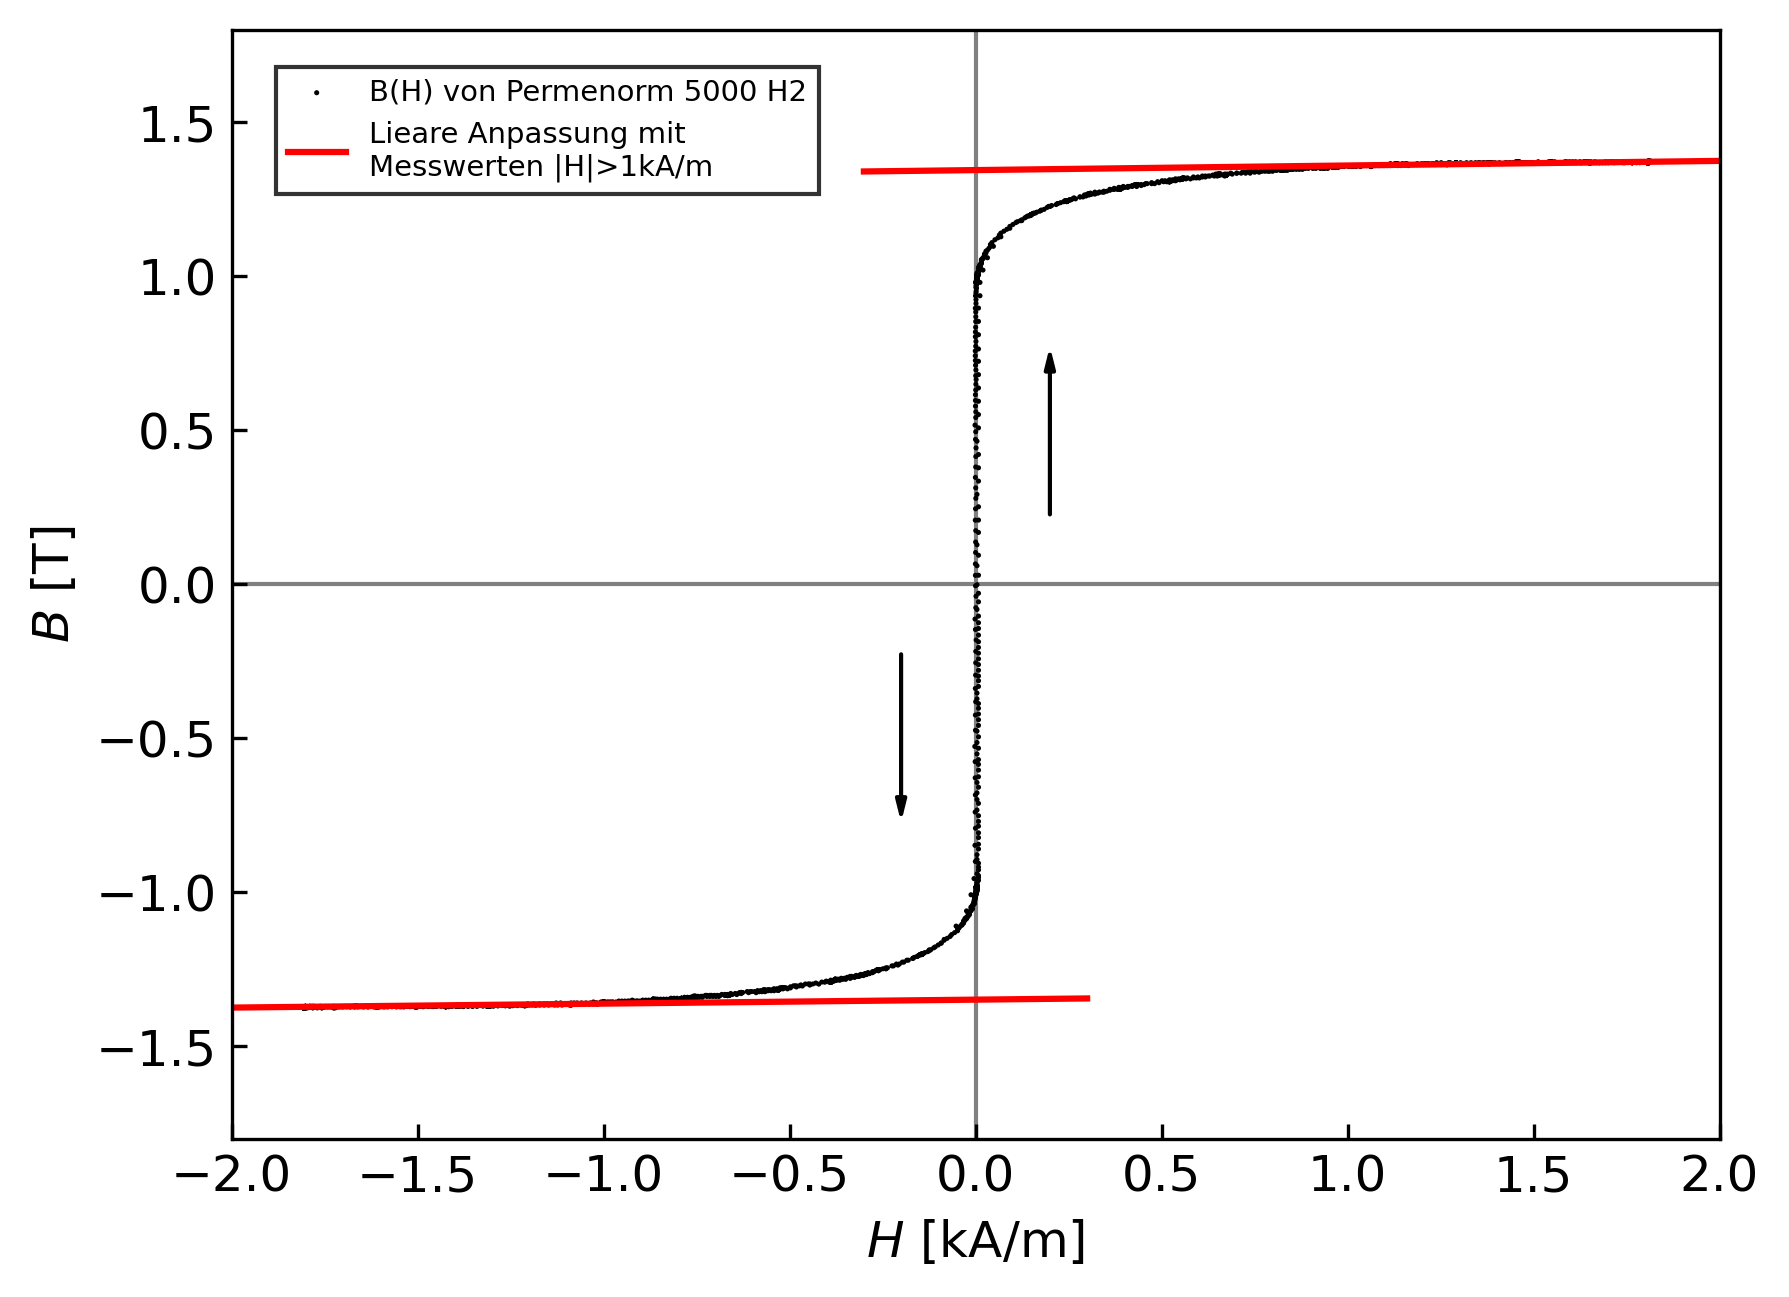

In [1182]:
plt3 = fig, ax = plt.subplots(dpi=300)

#Fit upper
x1_upper, x2_upper = 0.3, -5
y1_upper = b_opt_upper * x1_upper + a_opt_upper
y2_upper = b_opt_upper * x2_upper + a_opt_upper
x_clipped_upper = np.linspace(x1_upper, x2_upper, 400)
y_clipped_upper = model_f(x_clipped_upper, b_opt_upper, a_opt_upper)

#Fit lower
x1_lower, x2_lower = 5, -0.3
y1_lower = b_opt_lower * x1_lower + a_opt_lower
y2_lower = b_opt_lower * x2_lower + a_opt_lower
x_clipped_lower = np.linspace(x1_lower, x2_lower, 400)
y_clipped_lower = model_f(x_clipped_lower, b_opt_lower, a_opt_lower)

plt.scatter(x_data, y_data, marker='.', s=6, edgecolors='none', color='black', label='B(H) von Permenorm 5000 H2', zorder=2)
ax.set_xlim(-2, 2)
ax.set_ylim(-1.8, 1.8)
ax.set_ylabel('$B$ [T]', fontsize=12)
ax.set_xlabel('$H$ [kA/m]', fontsize=12)

plt.plot(x_clipped_upper, y_clipped_upper, color='red', linewidth=1.5, label='Lieare Anpassung mit \nMesswerten |H|>1kA/m', zorder=2)
plt.plot(x_clipped_lower, y_clipped_lower, color='red', linewidth=1.5, zorder=2)

#Arrows
#ax.arrow(-1, -0.4, -0.4 , -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black')
#ax.arrow(1, 0.4, 0.4 , 0.6, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.add_patch(FancyArrowPatch(posA=(-0.2, -0.2), posB=(-0.2, -0.8), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black"))
ax.add_patch(FancyArrowPatch(posA=(0.2, 0.2), posB=(0.2, 0.8), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black"))

#plt.grid(linewidth=0.5, linestyle='--')
ax.axhline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
ax.axvline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)
# plt.title('Bestimmung der Remanenz und Koerzitivfeldstärke', pad=10)
plt.show()

all_plots.append(plt3)

## Irreveribilität von Hyteresekurven

In [1183]:
file_path = '/Users/danielmiksch/Downloads/M7.csv'
data_m7 = pd.read_csv(file_path, sep=';')

In [1184]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m7.to_numpy()
data_np

array([[ 0.   , -1.016, -0.002],
       [ 0.02 , -1.016, -0.002],
       [ 0.04 , -1.016, -0.002],
       ...,
       [54.7  , -1.012, -0.002],
       [54.72 , -1.012, -0.003],
       [54.74 , -1.012, -0.002]])

### Symmetrisierung

In [1185]:
data_x = data_np[:, 1]
data_y = data_np[:, 2]

# fig, ax = plt.subplots(dpi=100)
# plt.scatter(data_x, data_y, s=0.1)

In [1186]:
N1, N2 = 1010, 53
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = 0.2 #[Ohm]
gamma = 0.1
F = 1
h = 0.03 #[m]
D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
data_korr = data_np.copy()
data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2
delta_U

0.506

In [1187]:
data_symm = data_korr.copy()
data_symm[:,2] -= delta_U

In [1188]:
data_trans = data_symm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_trans[:,1] = vec_H(data_trans[:,1])
data_trans[:,2] = vec_B(data_trans[:,2])

In [1189]:
x_data = data_trans[:,1]
y_data = data_trans[:,2]
# plt.plot(x_data, y_data)

### Making Plot

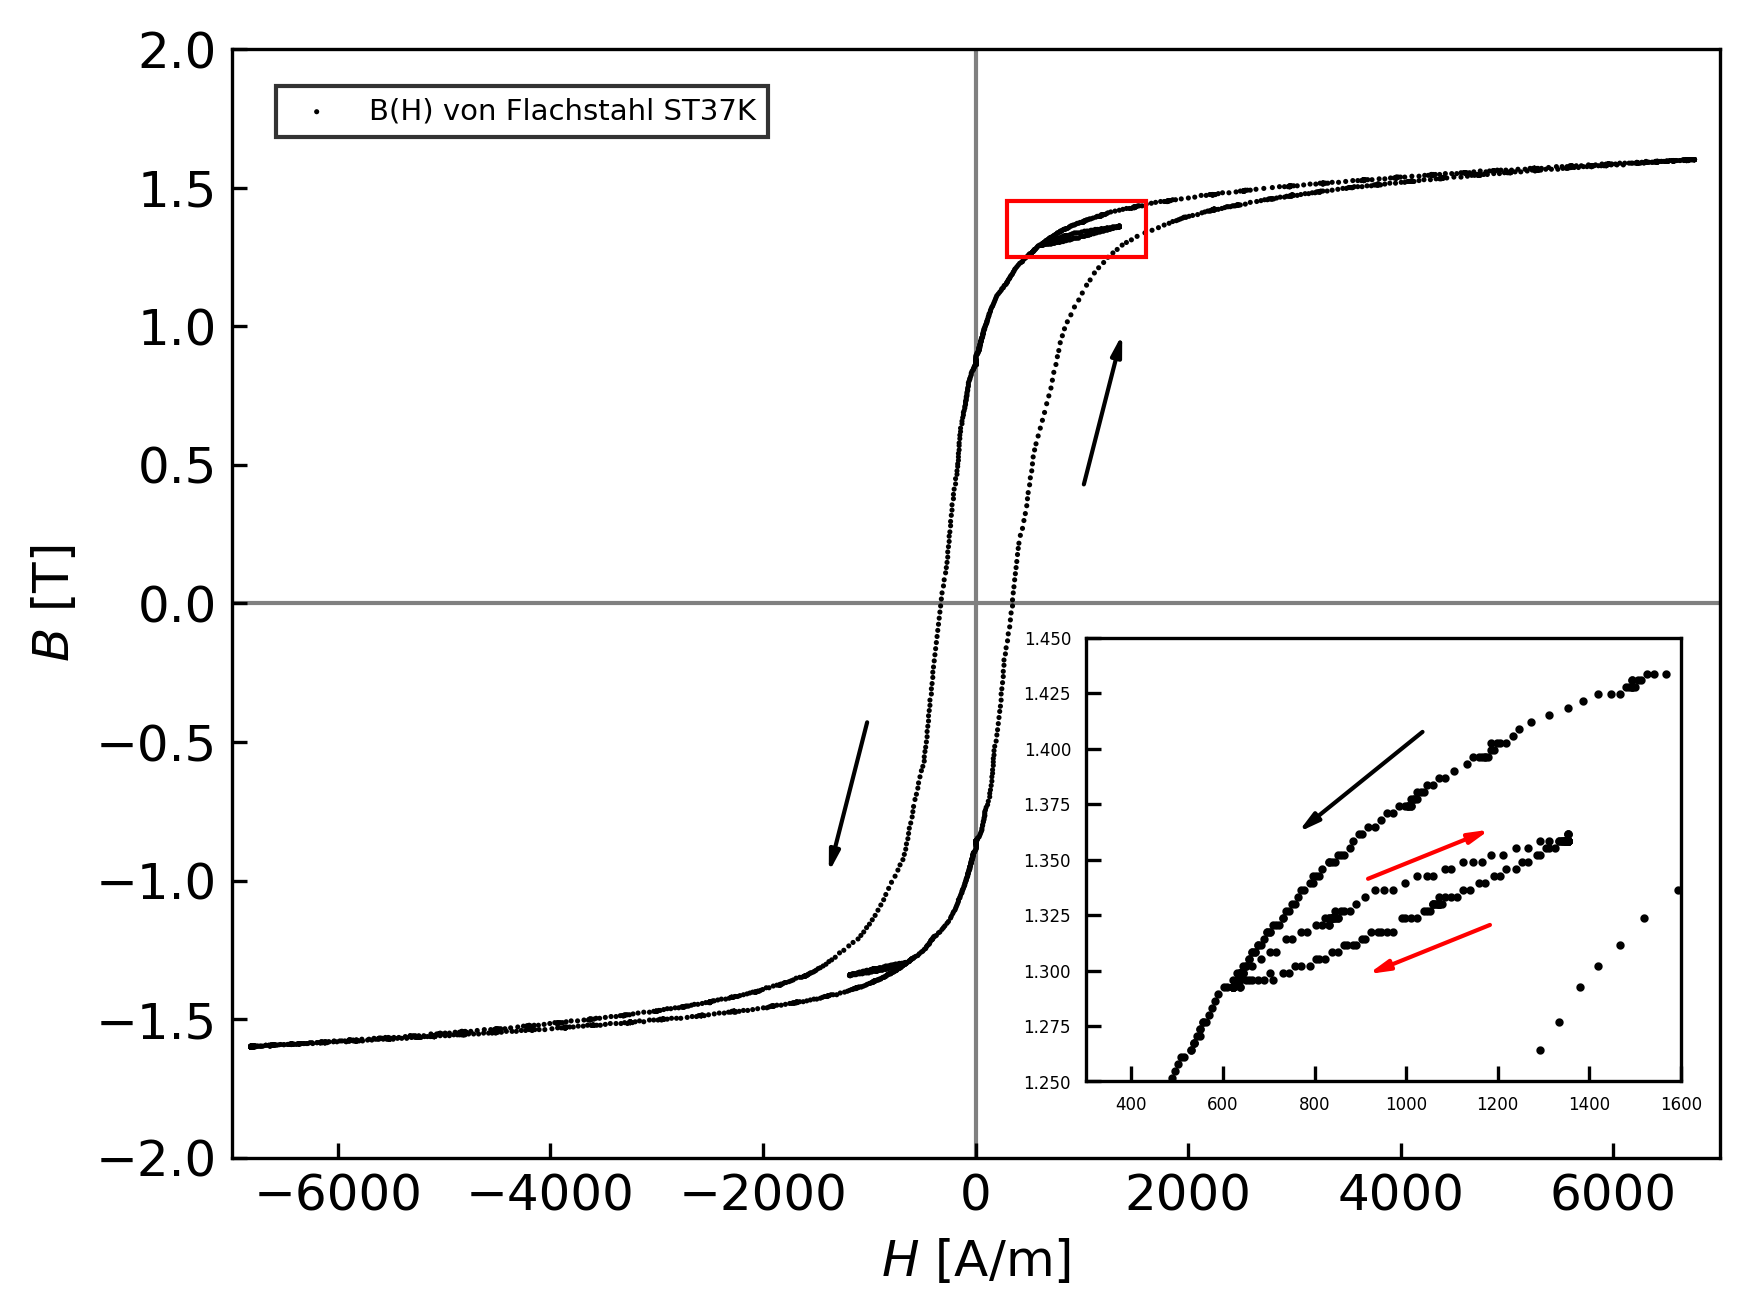

In [1190]:
plt4 = (fig, ax) = plt.subplots(dpi=300)

plt.scatter(x_data, y_data, marker='.', s=6, edgecolors='none', color='black', label='B(H) von Flachstahl ST37K', zorder=2)
ax.set_xlim(-7000, 7000)
ax.set_ylim(-2, 2)
ax.set_ylabel('$B$ [T]', fontsize=12)
ax.set_xlabel('$H$ [A/m]', fontsize=12)
#Arrows
#ax.arrow(-1, -0.4, -0.4 , -0.6, head_width=0.1, head_length=0.1, fc='black', ec='black')
#ax.arrow(1, 0.4, 0.4 , 0.6, head_width=0.1, head_length=0.1, fc='black', ec='black')
ax.add_patch(FancyArrowPatch(posB=(-1400, -1), posA=(-1000, -0.4), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black", zorder=2))
ax.add_patch(FancyArrowPatch(posB=(1400, 1), posA=(1000, 0.4), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black", zorder=2))

#plt.grid(linewidth=0.5, linestyle='--')
ax.axhline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
ax.axvline(0, color='grey', linestyle='-', linewidth=1, zorder=1)
plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)
# plt.title('Bestimmung der Remanenz und Koerzitivfeldstärke', pad=10)

axins = inset_axes(ax, 
                   width='80%', 
                   height='80%', 
                   bbox_to_anchor=(0.56, 0.05, 0.5, 0.5),
                   bbox_transform=ax.transAxes, 
                   loc='lower left')
x1, x2 = 300, 1600
y1, y2 = 1.25, 1.45

axins.add_patch(FancyArrowPatch(posA=(1050, 1.41), posB=(750, 1.36), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black"))
axins.add_patch(FancyArrowPatch(posA=(900, 1.34), posB=(1200, 1.365), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="red"))
axins.add_patch(FancyArrowPatch(posA=(1200, 1.322), posB=(900, 1.297), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="red"))

axins.tick_params(axis='both', which='major', labelsize=4, direction='in')
axins.scatter(x_data, y_data, s=1, color='black')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="red", alpha=1)


plt.show()

all_plots.append(plt4)

## Entmagnetisierung von Flachstahl

In [1191]:
file_path = '/Users/danielmiksch/Downloads/M8.csv'
data_m8 = pd.read_csv(file_path, sep=';')

4230


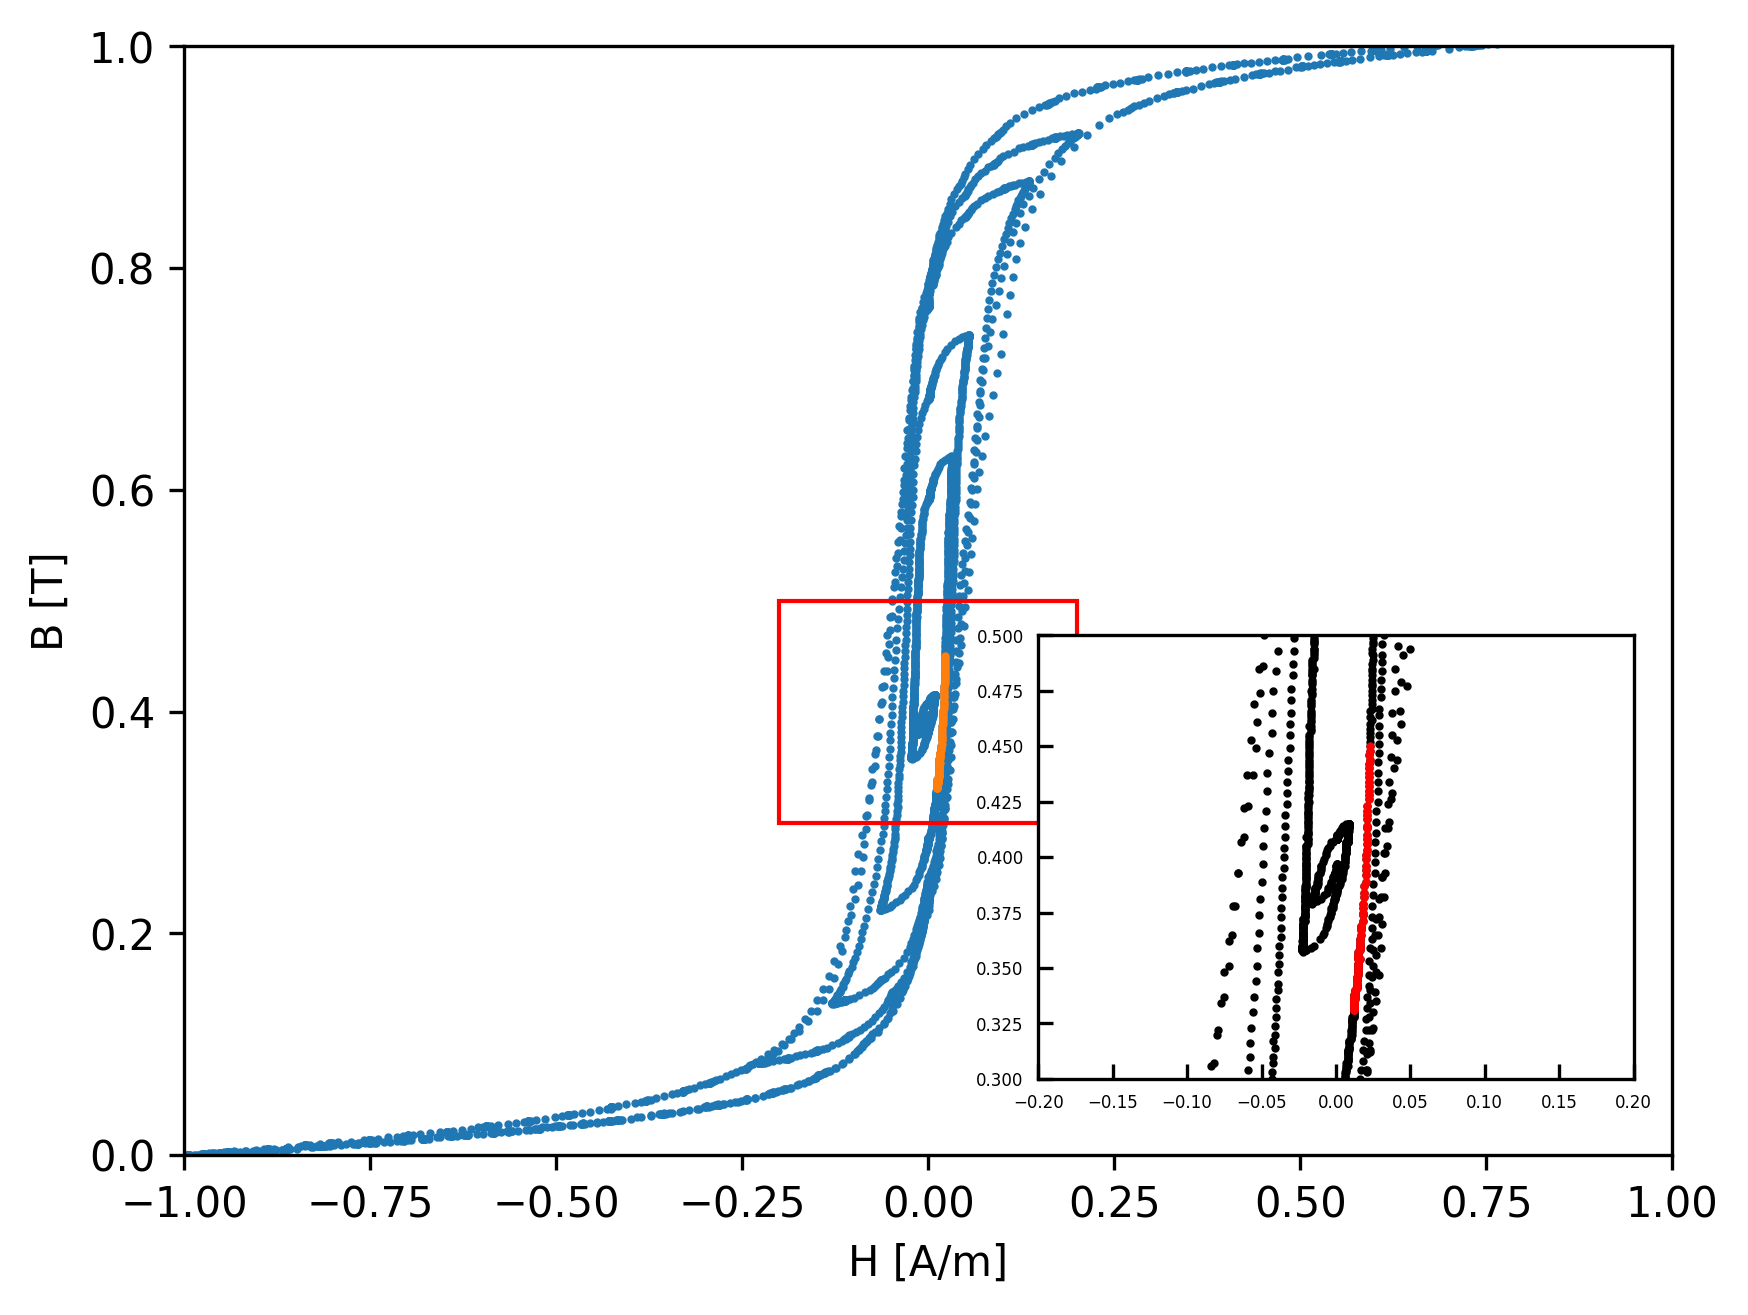

In [1192]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m8.to_numpy()

print(len(data_np))

x_plot, y_plot =data_np[3000:3100,1], data_np[3000:3100,2]

fig, ax = plt.subplots(dpi=300)
plt.scatter(data_np[:,1], data_np[:,2], s=1)
plt.scatter(x_plot, y_plot, s=1)

ax.set_xlim(-1, 1)
ax.set_ylim(0, 1)
ax.set_ylabel('B [T]')
ax.set_xlabel('H [A/m]')

axins = inset_axes(ax, 
                   width='80%', 
                   height='80%', 
                   bbox_to_anchor=(0.56, 0.05, 0.5, 0.5),
                   bbox_transform=ax.transAxes, 
                   loc='lower left')
x1, x2 = -0.2, 0.2
y1, y2 = 0.3, 0.5
# 
# axins.add_patch(FancyArrowPatch(posA=(1050, 1.41), posB=(750, 1.36), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black"))
# # axins.add_patch(FancyArrowPatch(posA=(900, 1.34), posB=(1200, 1.365), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="red"))
# # axins.add_patch(FancyArrowPatch(posA=(1200, 1.322), posB=(900, 1.297), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="red"))
# 
axins.tick_params(axis='both', which='major', labelsize=4, direction='in')
axins.scatter(data_np[:,1], data_np[:,2], s=1, color='black')
axins.scatter(x_plot, y_plot, s=1, color='red')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="red", alpha=1)


plt.show()

### Symmetrisierung

In [1193]:
data_x = data_np[:, 1]
data_y = data_np[:, 2]

# fig, ax = plt.subplots(dpi=100)
# plt.scatter(data_x, data_y, s=0.1)

In [1194]:
min_value = np.where(data_x < -1)
min_value

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075,
        1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1087, 1088, 1089,
        1090, 1091]),)

In [1195]:
N1, N2 = 1010, 53
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = 0.2 #[Ohm]
gamma = 0.1
F = 1
h = 0.03 #[m]
D_drift = (data_np[1067, 2] - data_np[0, 2]) / (data_np[1067, 0] - data_np[0, 0])
data_korr = data_np.copy()

data_korr_help = data_np[:1067].copy()
data_korr_help[:,2] = data_np[:1067,2] - (data_np[:1067,0] * D_drift)

data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)

delta_U = np.max(data_korr_help[:,2]) - (np.max(data_korr_help[:,2]) - np.min(data_korr_help[:,2])) / 2
delta_U

0.5077388514901593

In [1196]:
data_symm = data_korr.copy()
data_symm[:,2] -= delta_U

In [1197]:
data_trans = data_symm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_trans[:,1] = vec_H(data_trans[:,1])
data_trans[:,2] = vec_B(data_trans[:,2])

In [1198]:
x_data = data_trans[:,1]
y_data = data_trans[:,2]
# plt.plot(x_data, y_data)

### Making Plot

In [1199]:
def create_curved_arrow(x_data_arrow, y_data_arrow, start_idx, end_idx, num_points=500):
 
    t = np.linspace(0, 1, len(x_data_arrow))
    t_new = np.linspace(t[start_idx], t[end_idx], num_points)
    spline_x = make_interp_spline(t, x_data_arrow, k=1)
    spline_y = make_interp_spline(t, y_data_arrow, k=1)

    x_new = spline_x(t_new)
    y_new = spline_y(t_new)

    path = Path(np.column_stack([x_new, y_new]))

    arrow = FancyArrowPatch(path=path, color="red", arrowstyle="-|>, head_width=0.2, head_length=0.5", 
                            mutation_scale=10, linewidth=1.5, zorder=3)


    return arrow, x_new, y_new

In [1200]:
arrow1, x_test2, y_test2 = create_curved_arrow(x_data[2100:2200], y_data[2100:2200], 85, 90)
arrow2, x_test3, y_test3 = create_curved_arrow(x_data[2700:2800], y_data[2700:2800], 24, 34)
arrow3, x_test4, y_test4 = create_curved_arrow(x_data[3610:3700], y_data[3610:3700], 0, 50)
arrow4, x_test5, y_test5 = create_curved_arrow(x_data[3000:3100], y_data[3000:3100], 40, 80)

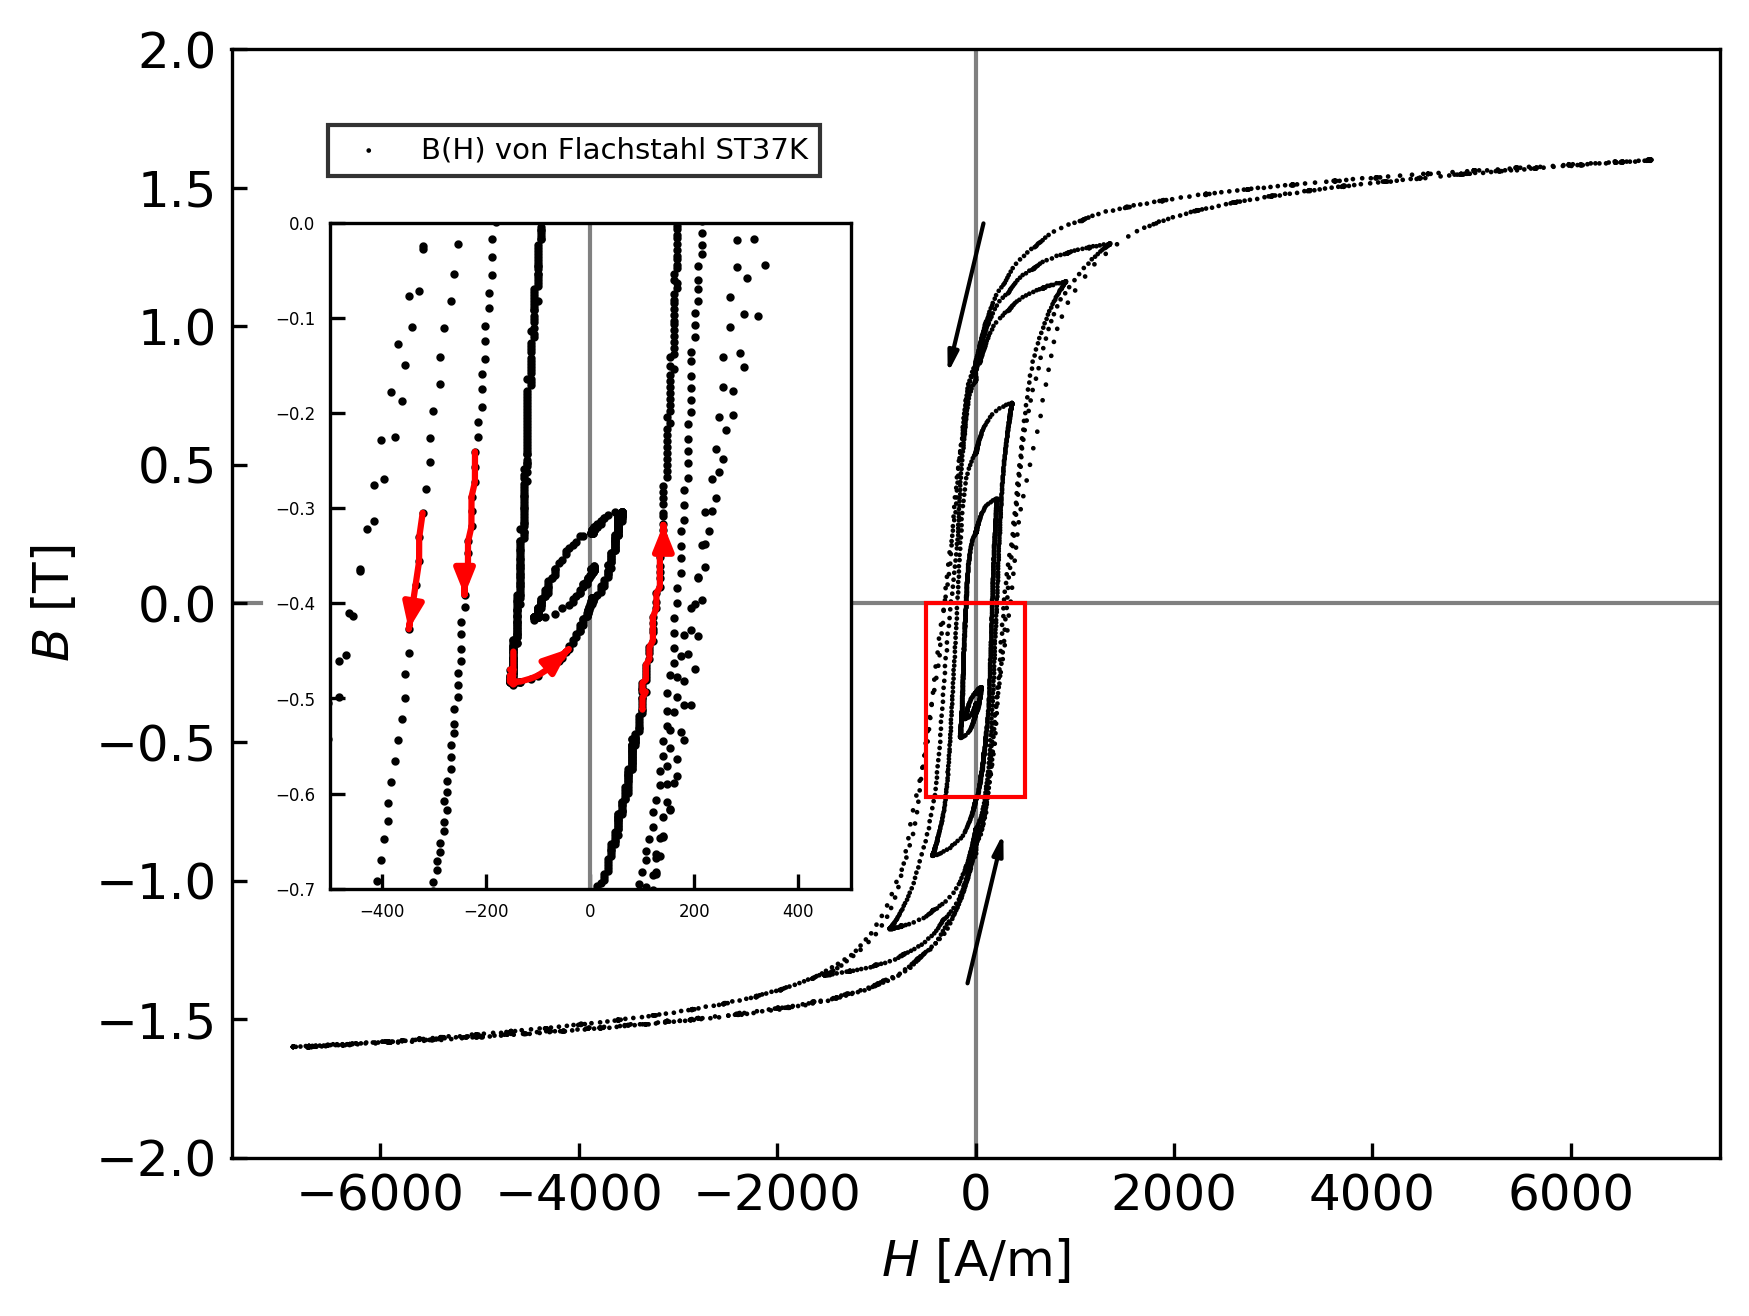

In [1201]:
plt5 = fig, ax = plt.subplots(dpi=300)

plt.scatter(x_data, y_data, marker='.', s=5, edgecolors='none', color='black', label='B(H) von Flachstahl ST37K', zorder=2)
ax.set_xlim(-7500, 7500)
ax.set_ylim(-2, 2)
ax.set_ylabel('$B$ [T]', fontsize=12)
ax.set_xlabel('$H$ [A/m]', fontsize=12)
#Arrows
ax.add_patch(FancyArrowPatch(posA=(100, 1.4), posB=(-300, 0.8), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black", zorder=2))
ax.add_patch(FancyArrowPatch(posA=(-100, -1.4), posB=(300, -0.8), mutation_scale=10, arrowstyle="-|>, head_width=0.1", color="black", zorder=2))

#plt.grid(linewidth=0.5, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(0.055, 0.945), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)
# plt.title('Bestimmung der Remanenz und Koerzitivfeldstärke', pad=10)

axins = inset_axes(ax, 
                   width='70%', 
                   height='120%', 
                   bbox_to_anchor=(0.052, 0.224, 0.5, 0.5),
                   bbox_transform=ax.transAxes, 
                   loc='lower left')
x1, x2 = -500,500
y1, y2 = -0.7, -0.0

axins.add_patch(arrow1)
axins.add_patch(arrow2)
axins.add_patch(arrow3)
axins.add_patch(arrow4)

axins.axvline(0, color='grey', linestyle='-', linewidth=1)
axins.tick_params(axis='both', which='major', labelsize=4, direction='in')
axins.scatter(x_data, y_data, s=1, color='black', zorder=2)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="red", alpha=1)

line1 = Line2D([0, 0], [2, -2], color='grey', linestyle='-', linewidth=1, zorder=1)
line2 = Line2D([-8000, -7200], [0, 0], color='grey', linestyle='-', linewidth=1, zorder=1)
line3 = Line2D([-4000, 8000], [0, 0], color='grey', linestyle='-', linewidth=1, zorder=1)
ax.add_line(line1)
ax.add_line(line2)
ax.add_line(line3)

# ax.axhline(0, color='grey', linestyle='-', linewidth=0.5, xmin=0, xmax=0.025)
# ax.axhline(0, color='grey', linestyle='-', linewidth=0.5, xmin=0.25, xmax=1)
# ax.axvline(0, color='grey', linestyle='-', linewidth=0.5)


plt.show()

all_plots.append(plt5)

## Hysteresekurve von Holz

In [1202]:
file_path = '/Users/danielmiksch/Downloads/M5.csv'
data_m5 = pd.read_csv(file_path, sep=';')

In [1203]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m5.to_numpy()
data_np

array([[ 0.   , -6.855,  0.053],
       [ 0.02 , -6.855,  0.054],
       [ 0.04 , -6.855,  0.053],
       ...,
       [14.1  , -7.006,  0.06 ],
       [14.12 , -7.007,  0.059],
       [14.14 , -7.006,  0.06 ]])

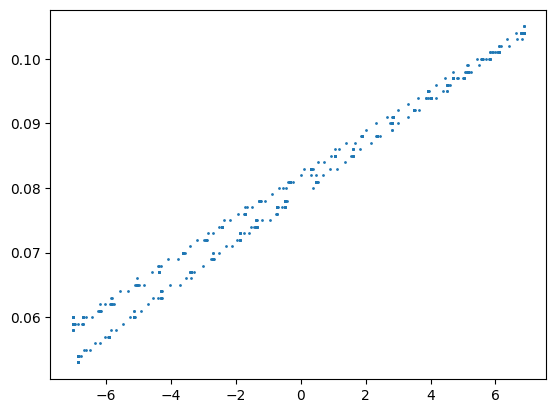

In [1204]:
plt.scatter(data_np[:,1], data_np[:,2], s=1)

In [1205]:
data_x = data_np[:, 1]
data_y = data_np[:, 2]

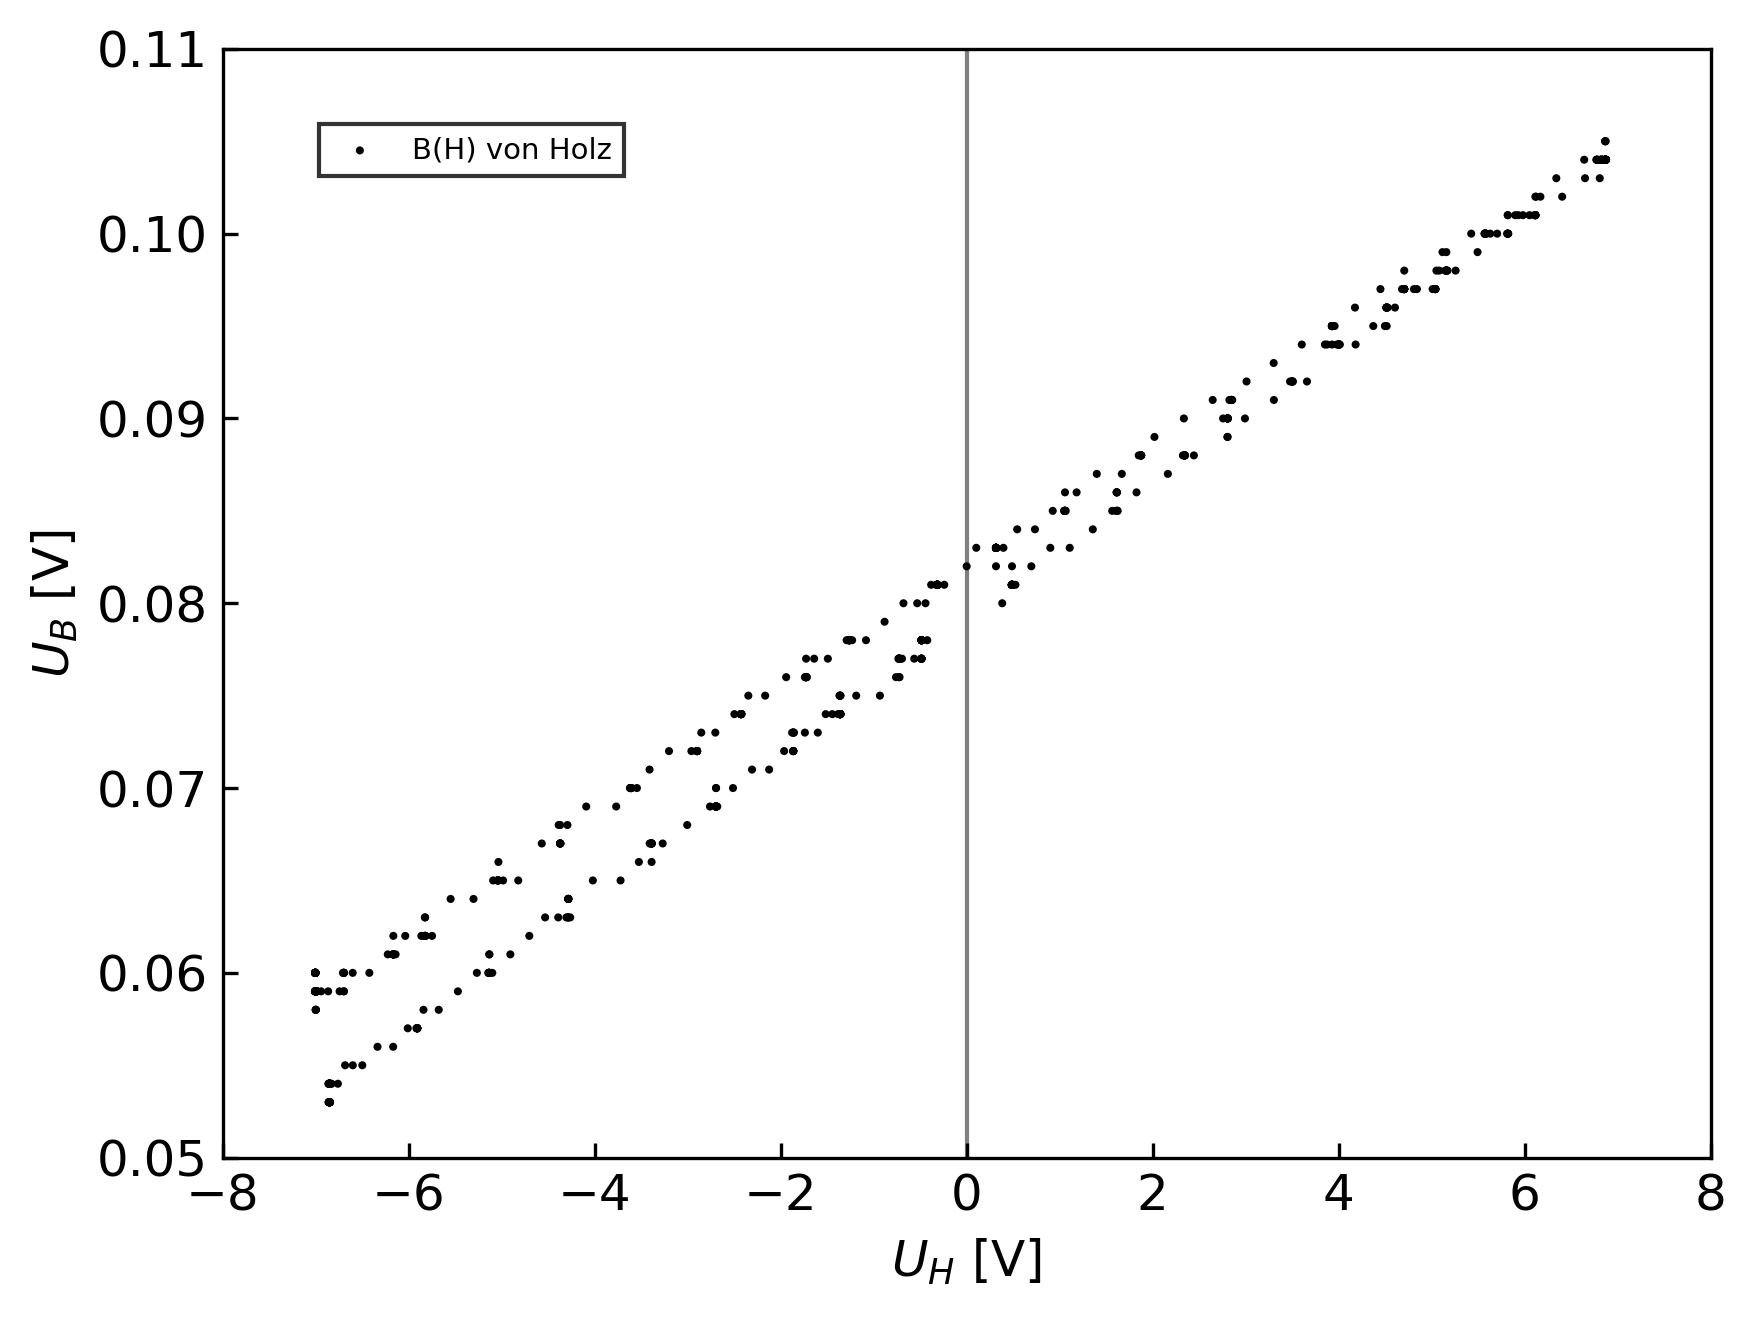

In [1206]:
plt6 = fig, ax = plt.subplots(dpi=300)

plt.scatter(data_x, data_y, marker='.', s=15, edgecolors='none', color='black', label='B(H) von Holz', zorder=2)
ax.set_xlim(-8, 8)
ax.set_ylim(0.05, 0.11)
ax.set_ylabel('$U_B$ [V]', fontsize=12)
ax.set_xlabel('$U_H$ [V]', fontsize=12)

#plt.grid(linewidth=0.5, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(0.055, 0.945), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)
# plt.title('Bestimmung der Remanenz und Koerzitivfeldstärke', pad=10)

line1 = Line2D([0, 0], [2, -2], color='grey', linestyle='-', linewidth=1, zorder=1)
line2 = Line2D([-8, 8], [0, 0], color='grey', linestyle='-', linewidth=1, zorder=1)
ax.add_line(line1)
ax.add_line(line2)

plt.show()

all_plots.append(plt6)

### Symmetrisierung

In [1207]:
min_value = np.where((data_x < -7.0069))
min_value

(array([704, 706]),)

In [1208]:
N1, N2 = 1010, 250
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = 67.7 #[Ohm]
gamma = (1 / 500)
F = 1
h = 0.03 #[m]
D_drift = (data_np[704, 2] - data_np[0, 2]) / (data_np[704, 0] - data_np[0, 0])
data_korr = data_np.copy()

data_korr_help = data_np[:704].copy()
data_korr_help[:,2] = data_np[:704,2] - (data_np[:704,0] * D_drift)

data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)

delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2
print(D_drift)
print(delta_U)

0.0004261363636363635
0.07735937500000001


In [1209]:
data_symm = data_korr.copy()
data_symm[:,2] -= delta_U

In [1210]:
data_trans = data_symm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_trans[:,1] = vec_H(data_trans[:,1])
data_trans[:,2] = vec_B(data_trans[:,2])

array([-0.3247916667, -0.3115719697, -0.3250189394, -0.3251325758,
       -0.3252462121, -0.3120265152, -0.3254734848, -0.3122537879,
       -0.3123674242, -0.3258143939, -0.312594697 , -0.3260416667,
       -0.3128219697, -0.3129356061, -0.3263825758, -0.3131628788,
       -0.3266098485, -0.3267234848, -0.3268371212, -0.3269507576,
       -0.3270643939, -0.3271780303, -0.3139583333, -0.327405303 ,
       -0.3275189394, -0.3142992424, -0.3277462121, -0.3145265152,
       -0.3279734848, -0.3147537879, -0.3148674242, -0.3283143939,
       -0.3284280303, -0.3152083333, -0.3153219697, -0.3154356061,
       -0.3155492424, -0.3156628788, -0.3157765152, -0.3158901515,
       -0.3160037879, -0.3161174242, -0.3295643939, -0.316344697 ,
       -0.3164583333, -0.3165719697, -0.3033522727, -0.3034659091,
       -0.3035795455, -0.2903598485, -0.2904734848, -0.2772537879,
       -0.2773674242, -0.2774810606, -0.277594697 , -0.2777083333,
       -0.2778219697, -0.2779356061, -0.2780492424, -0.2781628

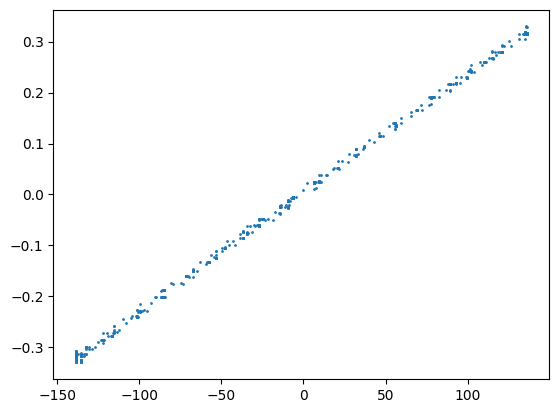

In [1211]:
x_data = data_trans[:,1]
y_data = data_trans[:,2] * 1000

plt.scatter(x_data, y_data, s=1)
y_data
# plt.plot(x_data, y_data)

### Linearer Fit

In [1212]:
popt_holz, pcov_holz = curve_fit(model_f, x_data, y_data / 1000, p0=[0, 0])

In [1213]:
b_opt_holz, a_opt_holz = popt_holz

In [1214]:
mu_0 = 1.256637062e-6
mu_holz = b_opt_holz / mu_0
mu_holz

1.8601464021289091

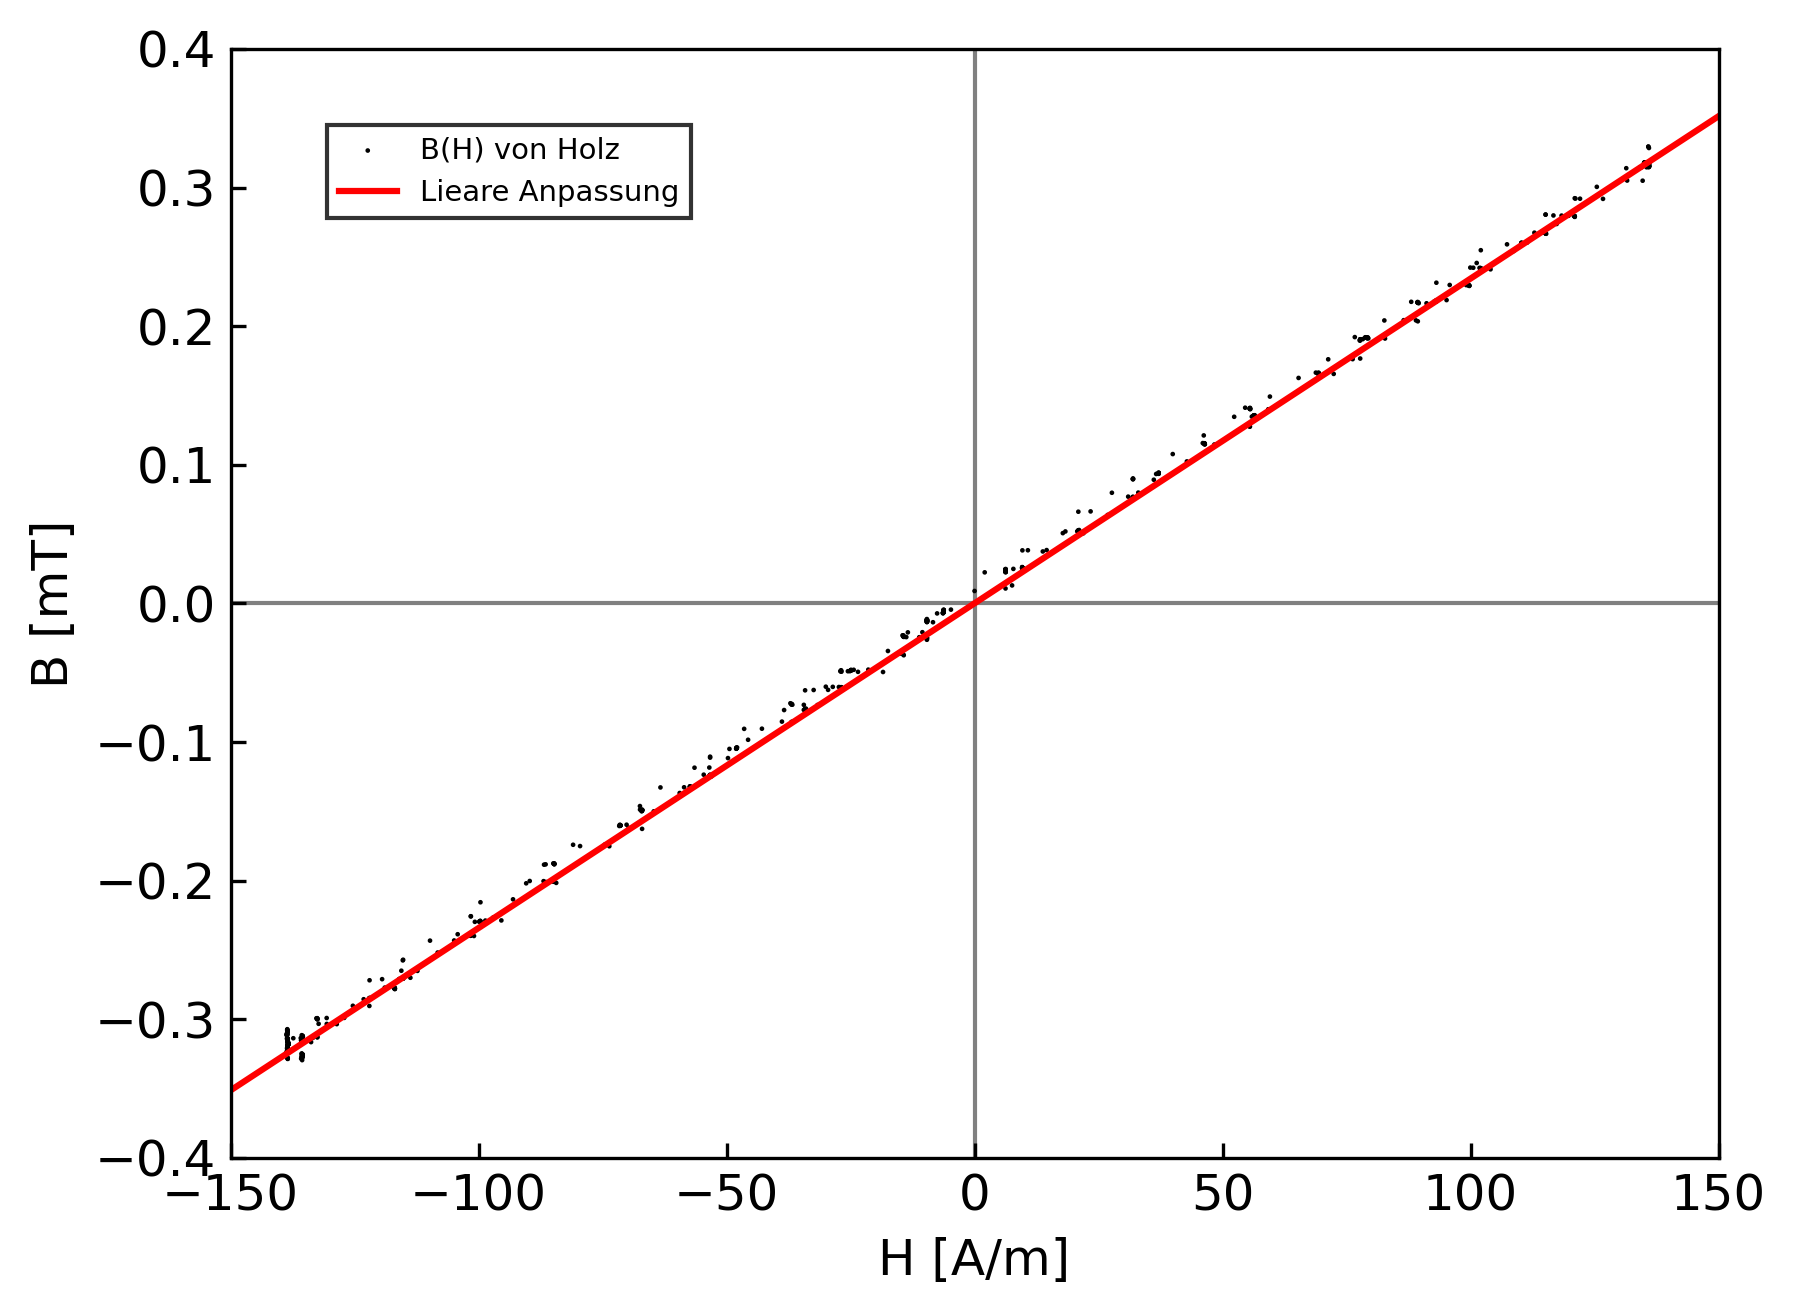

In [1215]:
plt7 = fig, ax = plt.subplots(dpi=300)

x_fit_holz = np.linspace(-150, 150, 1000)
y_fit_holz = model_f(x_fit_holz, 0.0000023429 * 1000, 0.0000063098)

plt.scatter(x_data, y_data, marker='.', s=5, edgecolors='none', color='black', label='B(H) von Holz', zorder=2)
ax.set_ylim(-0.4, 0.4)
ax.set_xlim(-150, 150)
ax.set_ylabel('B [mT]', fontsize=12)
ax.set_xlabel('H [A/m]', fontsize=12)

plt.plot(x_fit_holz, y_fit_holz, color='red', linewidth=1.5, label='Lieare Anpassung')

#plt.grid(linewidth=0.5, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(0.055, 0.945), fancybox=False, edgecolor='black', fontsize=7)
plt.tick_params(direction='in', labelsize=12)
# plt.title('Bestimmung der Remanenz und Koerzitivfeldstärke', pad=10)

line1 = Line2D([0, 0], [20, -20], color='grey', linestyle='-', linewidth=1, zorder=1)
line2 = Line2D([-150, 150], [0, 0], color='grey', linestyle='-', linewidth=1, zorder=1)
ax.add_line(line1)
ax.add_line(line2)

plt.show()

all_plots.append(plt7)

## Ergebnisse Hysterese Permenorm 5000 H2

In [1216]:
def H(U):
    return (N1 * U) / (np.pi * d * R_u)

def B(U):
    return (2 * gamma * U) / (N2 * (d_a - d_i) * h * F)

def model_f1(p, x):
    m, b = p
    return m*x + b

def model_f(x, b, a):
    return b * x + a

def weighted_avg(popt1, popt2, pcov1, pcov2, value):
    if value == 'b':
        param = 0
    if value == 'a':
        param = 1
    data = np.array([popt1[param], popt2[param]])
    pcov = np.array([pcov1[param, param], pcov2[param, param]])
    return np.average(abs(data), weights=1 / pcov), np.sqrt(1 / sum(1 / pcov))

In [1217]:
file_path = '/Users/danielmiksch/Downloads/M1.csv'
data_m1 = pd.read_csv(file_path, sep=';')
np.set_printoptions(suppress=True, precision=10)
data_np = data_m1.to_numpy()

In [1218]:
d_Flux = ufloat(0, (100 / 1000) * 0.025)
d_Inter = ufloat(0, 0.00122)
d_U = unumpy.std_devs(d_Inter + d_Flux) #[V]
N1, N2 = 605, 80
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R_u = ufloat(67.6, 0.1) #[Ohm]
gamma= 0.1
F = 0.9
h = 0.03 #[m]

data_col1 = data_np[:, 1].copy()
data_col2 = data_np[:, 2].copy()

udata1 = unumpy.uarray(data_col1, d_U)
udata2 = unumpy.uarray(data_col2, d_U)
data_unp = np.column_stack((data_np[:,0], udata1, udata2))
# D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
# data_korr = data_np.copy()
# data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
# delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2

D_drift = (data_unp[-1, 2] - data_unp[0, 2]) / (data_unp[-1, 0] - data_unp[0, 0])
data_ukorr = data_unp.copy()
data_ukorr[:,2] = data_unp[:,2] - (data_unp[:,0] * D_drift)
delta_U = np.max(data_ukorr[:,2]) - (np.max(data_ukorr[:,2]) - np.min(data_ukorr[:,2])) / 2

In [1219]:
data_usymm = data_ukorr.copy()
data_usymm[:,2] -= delta_U

In [1220]:
data_utrans = data_usymm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_utrans[:,1] = vec_H(data_utrans[:,1])
data_utrans[:,2] = vec_B(data_utrans[:,2])
data_utrans

array([[0.0, -79.39785326389563+/-0.12200564627103862,
        -0.8680546905275976+/-0.006829392091373718],
       [0.02, -79.39785326389563+/-0.12200564627103862,
        -0.8657381456568676+/-0.010429593794115037],
       [0.04, -79.39785326389563+/-0.12200564627103862,
        -0.8680512304157668+/-0.010427367232069997],
       ...,
       [53.48, -83.63541248279392+/-0.1280515232460064,
        -0.8657433358246137+/-0.008207174928539783],
       [53.5, -83.63541248279392+/-0.1280515232460064,
        -0.8657416057686983+/-0.008208117467462668],
       [53.52, -83.63541248279392+/-0.1280515232460064,
        -0.8680546905275976+/-0.006829392091373718]], dtype=object)

In [1221]:
x_udata = data_utrans[:,1]
y_udata = data_utrans[:,2]

In [1222]:
half_hyst = np.argmax(x_udata)

In [1223]:
nominal_values = unumpy.nominal_values(data_utrans)
std_devs = unumpy.std_devs(data_utrans)
data_trans = np.column_stack((nominal_values, std_devs[:,1:]))

In [1224]:
data_interp = data_trans[half_hyst:]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data1 = data_interp[unique_indices]
f_cubic1_best = interp1d(filtered_data1[:,1], filtered_data1[:,2], kind='cubic')
f_cubic1_max = interp1d(filtered_data1[:,1], filtered_data1[:,2] + filtered_data1[:,4], kind='cubic')
x = np.linspace(-79, 80, 1000)
# plt.scatter(filtered_data[:,1], filtered_data[:,2], s=1)
# plt.plot(x, f_cubic(x))

In [1225]:
data_interp = data_trans[:half_hyst]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data2 = data_interp[unique_indices]
f_cubic2_best = interp1d(filtered_data2[:,1], filtered_data2[:,2], kind='cubic')
f_cubic2_max = interp1d(filtered_data2[:,1], filtered_data2[:,2] - filtered_data2[:,4], kind='cubic')
# plt.plot(x, f_cubic2_max(x))
# plt.plot(x, f_cubic1_max(x))

In [1226]:
def difference_best(x):
    return abs(f_cubic1_best(x) - f_cubic2_best(x))

def difference_max(x):
    return abs(f_cubic1_max(x) - f_cubic2_max(x))

# Berechnen Sie das Integral über den Bereich [a, b]
area_best, _ = quad(difference_best, -79, 80)
area_max, _ = quad(difference_max, -79, 80)
print(area_best)
print(area_max)
area_FE = ufloat(area_best, area_max - area_best)

12.85307155934507
15.593403993309105


/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_87764/1157160739.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area_best, _ = quad(difference_best, -79, 80)
/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_87764/1157160739.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from sp

In [1227]:
ro_FE = 8250
(area_FE / ro_FE) * 1000

1.5579480677994024+/-0.33216150714715575

### Fit upper

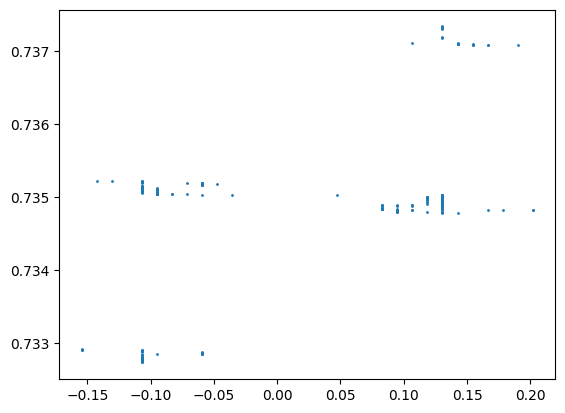

In [1228]:
data_trans_upper = data_trans[half_hyst:]
indices_upper = np.where((data_trans_upper[:,1]>-0.2) * (data_trans_upper[:,1]<0.2))[0]
lower_index_upper = indices_upper[[0, -1]][0]
upper_index_upper = indices_upper[[0, -1]][1]

data_fit_upper = data_trans_upper[lower_index_upper:upper_index_upper]
x_fit_upper = data_fit_upper[:,1]
y_fit_upper = data_fit_upper[:,2]
sx_upper = data_fit_upper[:,3]
sy_upper = data_fit_upper[:,4]
plt.scatter(x_fit_upper, y_fit_upper, s=1)

# popt_upper_FE, pcov_upper_FE = curve_fit(model_f, x_fit_upper, y_fit_upper, p0=[0, 0])
# print(popt_upper_FE)
# pcov_upper_FE


In [1229]:
model = Model(model_f1)
data = RealData(x_fit_upper, y_fit_upper, sx=sx_upper, sy=sy_upper)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_test, pcov_test = curve_fit(model_f, x_fit_upper, y_fit_upper, sigma=sy_upper, absolute_sigma=True)

print(popt_test)
print(pcov_test)

popt_upper_FE, pcov_upper_FE = output.beta, output.cov_beta



Beta: [0.005033604  0.7345894366]
Beta Std Error: [0.0004987229 0.000057654 ]
Beta Covariance: [[ 0.0000187427 -0.0000005667]
 [-0.0000005667  0.0000002505]]
Residual Variance: 0.01327044955596972
Inverse Condition #: 0.11864218147416895
Reason(s) for Halting:
  Sum of squares convergence
[0.0050277778 0.7345896128]
[[ 0.0000187355 -0.0000005664]
 [-0.0000005664  0.0000002504]]


### Fit lower

In [1230]:
data_trans_lower = data_trans[:half_hyst]
indices_lower = np.where((data_trans_lower[:,1]>-0.2) * (data_trans_lower[:,1]<0.2))[0]
lower_index_lower = indices_lower[[0, -1]][0]
upper_index_lower = indices_lower[[0, -1]][1]

data_fit_lower = data_trans_lower[lower_index_lower:upper_index_lower]
x_fit_lower = data_fit_lower[:,1]
y_fit_lower = data_fit_lower[:,2]
sx_lower = data_fit_lower[:,3]
sy_lower = data_fit_lower[:,4]


In [1231]:
model = Model(model_f1)
data = RealData(x_fit_lower, y_fit_lower, sx=sx_lower, sy=sy_lower)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_lower_FE, pcov_lower_FE = output.beta, output.cov_beta

Beta: [ 0.0073806885 -0.7354815839]
Beta Std Error: [0.0004523397 0.000076548 ]
Beta Covariance: [[0.000014521  0.0000002037]
 [0.0000002037 0.0000004158]]
Residual Variance: 0.014090721388684554
Inverse Condition #: 0.1887490489940489
Reason(s) for Halting:
  Sum of squares convergence


In [1232]:
B_perm = weighted_avg(popt_upper_FE, popt_lower_FE, pcov_upper_FE, pcov_lower_FE, 'a')
print("B Perenorm: {} +/- {} mT".format(B_perm[0] * 1000, B_perm[1] * 1000))
# popt_upper_FE

B Perenorm: 734.9248050544131 +/- 0.39537550177839026 mT


### Fit left

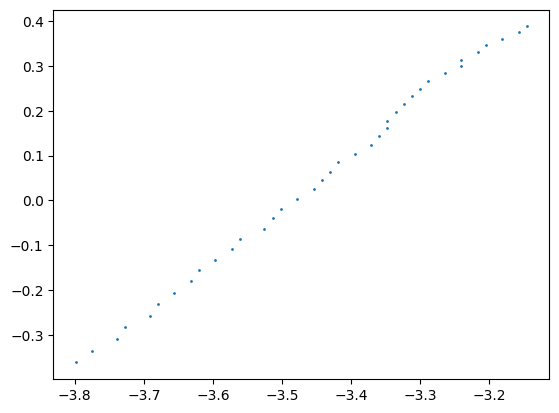

In [1233]:
#y_test= data_trans[:,2][(data_trans[:,2]>-0.75) * (data_trans[:,2]<0.75)]
data_trans_left = data_trans[half_hyst:]
indices_left = np.where((data_trans_left[:,2]>-0.4) * (data_trans_left[:,2]<0.4))[0]
lower_index_left = indices_left[[0, -1]][0]
upper_index_left = indices_left[[0, -1]][1]

data_fit_left = data_trans_left[lower_index_left:upper_index_left]
x_fit_left = data_fit_left[:,1]
y_fit_left = data_fit_left[:,2]
sx_left = data_fit_left[:,3]
sy_left = data_fit_left[:,4]
data_fit_left
plt.scatter(x_fit_left, y_fit_left, s=1)
#plt.scatter(x_data_fit1, y_data_fit1, s=0.1)

In [1234]:
model_left = Model(model_f1)
data_left = RealData(x_fit_left, y_fit_left, sx=sx_left, sy=sy_left)
myodr = ODR(data_left, model_left, beta0=[0., 0.])

output = myodr.run()
output.pprint()


Beta: [1.2117926005 4.2256570951]
Beta Std Error: [0.0111492051 0.0384386923]
Beta Covariance: [[0.0013266194 0.0045672344]
 [0.0045672344 0.0157686947]]
Residual Variance: 0.09370040428810977
Inverse Condition #: 0.012129318860578506
Reason(s) for Halting:
  Sum of squares convergence


In [1235]:
popt_left_FE, pcov_left_FE = output.beta, output.cov_beta

In [1236]:
y_predicted = model_f1(output.beta, x_fit_left)
residuals = y_fit_left - y_predicted

chi2 = sum((residuals / sy_left) ** 2)
n = len(y_fit_left) - len(output.beta)

red_Chi2 = chi2 / n
red_Chi2

2.5311351627248144

In [1237]:
r, p = pearsonr(x_fit_left, y_fit_left)
r, p

(0.9984823974453215, 6.2351781158267715e-47)

### Fit right

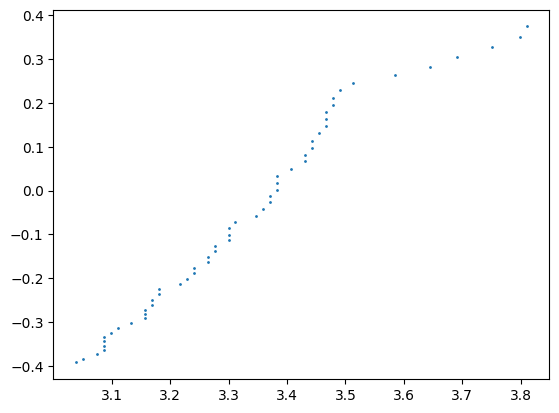

In [1238]:
data_trans_right = data_trans[:half_hyst]
indices_right = np.where((data_trans_right[:,2]>-0.4) * (data_trans_right[:,2]<0.4))[0]
lower_index_right = indices_right[[0, -1]][0]
upper_index_right = indices_right[[0, -1]][1]

data_fit_right = data_trans_right[lower_index_right:upper_index_right]
x_fit_right = data_fit_right[:,1]
y_fit_right = data_fit_right[:,2]
sx_right = data_fit_right[:,3]
sy_right = data_fit_right[:,4]
plt.scatter(x_fit_right, y_fit_right, s=1)

In [1239]:
model_right = Model(model_f1)
data_right = RealData(x_fit_right, y_fit_right, sx=sx_right, sy=sy_right)
myodr = ODR(data_right, model_right, beta0=[0., 0.])

output = myodr.run()
output.pprint()


Beta: [ 1.1862433457 -4.0089091583]
Beta Std Error: [0.0333844969 0.1112910464]
Beta Covariance: [[ 0.0008528554 -0.0028385953]
 [-0.0028385953  0.0094777702]]
Residual Variance: 1.3068155033058235
Inverse Condition #: 0.013142877972870259
Reason(s) for Halting:
  Sum of squares convergence


In [1240]:
popt_right_FE, pcov_right_FE = output.beta, output.cov_beta
popt_right_FE

array([ 1.1862433457, -4.0089091583])

In [1241]:
y_predicted = model_f1(output.beta, x_fit_right)
residuals = y_fit_right - y_predicted

chi2 = sum((residuals / sy_right) ** 2)
n = len(y_fit_right) - len(output.beta)

red_Chi2 = chi2 / n
red_Chi2

27.587341455993784

In [1242]:
r, p = pearsonr(x_fit_right, y_fit_right)
r, p

(0.9795363121612014, 1.4008957809668084e-38)

### Korzitivfelstäreke H2

In [1243]:
H_left = - ufloat(popt_left_FE[1], pcov_left_FE[1, 1]) / ufloat(popt_left_FE[0], pcov_left_FE[0, 0])
H_right = - ufloat(popt_right_FE[1], pcov_right_FE[1, 1]) / ufloat(popt_right_FE[0], pcov_right_FE[0, 0])
H_FE = np.array([unumpy.nominal_values(H_left), unumpy.nominal_values(H_right)])
d_H_FE = np.array([unumpy.std_devs(H_left), unumpy.std_devs(H_right)])
print(H_left)
print(H_right)

-3.487+/-0.014
3.379+/-0.008


In [1244]:
H_avg = np.average(abs(H_FE), weights=1 / d_H_FE)
d_H_avg = np.sqrt(1 / sum(1 / d_H_FE))

In [1245]:
print("H Perenorm: {} +/- {} A/m".format(H_avg, d_H_avg))

H Perenorm: 3.42051244805319 +/- 0.07189107448694698 A/m


## Ergebnisse Flachstahl ST37K

In [1246]:
file_path = '/Users/danielmiksch/Downloads/M6.csv'
data_m6 = pd.read_csv(file_path, sep=';')
np.set_printoptions(suppress=True, precision=10)
data_np = data_m6.to_numpy()

In [1247]:
d_Flux = ufloat(0, (100 / 1000) * 0.025)
d_Inter = ufloat(0, 0.00122)
d_U = unumpy.std_devs(d_Inter + d_Flux) #[V]
N1, N2 = 1010, 53
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R_u = ufloat(0.2, 0.1) #[Ohm]
gamma= 0.1
F = 1
h = 0.03 #[m]

data_col1 = data_np[:, 1].copy()
data_col2 = data_np[:, 2].copy()

udata1 = unumpy.uarray(data_col1, d_U)
udata2 = unumpy.uarray(data_col2, d_U)
data_unp = np.column_stack((data_np[:,0], udata1, udata2))
# D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
# data_korr = data_np.copy()
# data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
# delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2

D_drift = (data_unp[-1, 2] - data_unp[0, 2]) / (data_unp[-1, 0] - data_unp[0, 0])
data_ukorr = data_unp.copy()
data_ukorr[:,2] = data_unp[:,2] - (data_unp[:,0] * D_drift)
delta_U = np.max(data_ukorr[:,2]) - (np.max(data_ukorr[:,2]) - np.min(data_ukorr[:,2])) / 2

In [1248]:
data_usymm = data_ukorr.copy()
data_usymm[:,2] -= delta_U

In [1249]:
data_utrans = data_usymm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_utrans[:,1] = vec_H(data_utrans[:,1]) / 1000
data_utrans[:,2] = vec_B(data_utrans[:,2])
data_utrans

array([[0.0, -6.751352685958201+/-3.3757277612654804,
        -1.5997036381435137+/-0.009110614018694537],
       [0.02, -6.751352685958201+/-3.3757277612654804,
        -1.5997022971396384+/-0.01381758654138946],
       [0.04, -6.751352685958201+/-3.3757277612654804,
        -1.5997009561357625+/-0.01381425561073031],
       ...,
       [46.86, -6.7647482270017685+/-3.3824254299704215,
        -1.599706320151265+/-0.011311932694584753],
       [46.88, -6.758050456479984+/-3.379076595567498,
        -1.5965603250593388+/-0.011313626548116632],
       [46.9, -6.7647482270017685+/-3.3824254299704215,
        -1.5997036381435137+/-0.009110614018694537]], dtype=object)

In [1250]:
x_udata = data_utrans[:,1]
y_udata = data_utrans[:,2]

In [1251]:
half_hyst = np.argmax(x_udata)

In [1252]:
nominal_values = unumpy.nominal_values(data_utrans)
std_devs = unumpy.std_devs(data_utrans)
data_trans = np.column_stack((nominal_values, std_devs[:,1:]))

In [1253]:
data_interp = data_trans[half_hyst:]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data1 = data_interp[unique_indices]
f_cubic1_best = interp1d(filtered_data1[:,1] * 1000, filtered_data1[:,2], kind='linear')
f_cubic1_max = interp1d(filtered_data1[:,1] * 1000, filtered_data1[:,2] + filtered_data1[:,4], kind='linear')
x = np.linspace(-6758, 6704, 1000)
# plt.scatter(filtered_data1[:,1], filtered_data1[:,2], s=1)
# plt.plot(x, f_cubic(x))

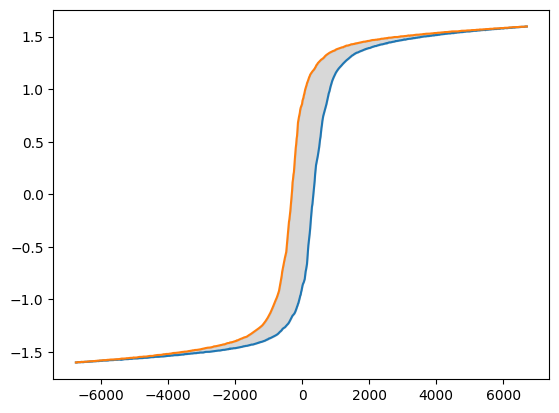

In [1254]:
data_interp = data_trans[:half_hyst]
_, unique_indices = np.unique(data_interp[:, 1], return_index=True)
filtered_data2 = data_interp[unique_indices]
f_cubic2_best = interp1d(filtered_data2[:,1] * 1000, filtered_data2[:,2], kind='linear')
f_cubic2_max = interp1d(filtered_data2[:,1] * 1000, filtered_data2[:,2] - filtered_data2[:,4], kind='linear')
plt.plot(x, f_cubic2_best(x))
plt.plot(x, f_cubic1_best(x))
plt.fill_between(x, f_cubic1_best(x), f_cubic2_best(x), color='gray', alpha=0.3)

In [1255]:
def difference_best(x):
    return abs(f_cubic1_best(x) - f_cubic2_best(x))

def difference_max(x):
    return abs(f_cubic1_max(x) - f_cubic2_max(x))

# Berechnen Sie das Integral über den Bereich [a, b]
area_best, _ = quad(difference_best, -6758, 6704)
area_max, _ = quad(difference_max, -6758, 6704)
print(area_best)
print(area_max)
area_ST = ufloat(area_best, area_max - area_best)

2203.4977978712586
2514.7319528884323


/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_87764/3327612648.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area_best, _ = quad(difference_best, -6758, 6704)
/var/folders/_s/ymfv76ms5rs0hd9l43mh92_80000gn/T/ipykernel_87764/3327612648.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain fro

In [1256]:
ro_ST = 7800
(area_ST / ro_ST)

0.2824997176758024+/-0.03990181474579149

### Fit upper

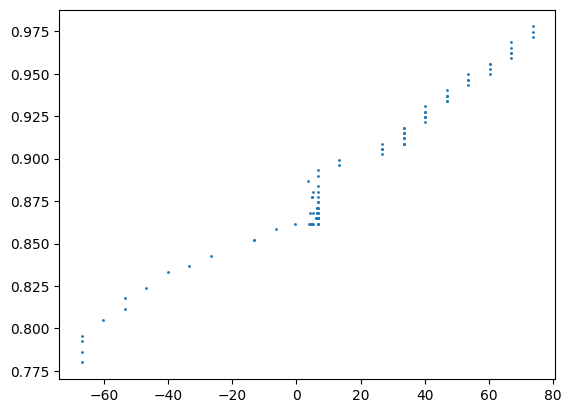

In [1257]:
data_trans_upper = data_trans[half_hyst:]
indices_upper = np.where((data_trans_upper[:,1]>-0.08) * (data_trans_upper[:,1]<0.08))[0]
lower_index_upper = indices_upper[[0, -1]][0]
upper_index_upper = indices_upper[[0, -1]][1]

data_fit_upper = data_trans_upper[lower_index_upper:upper_index_upper]
x_fit_upper = data_fit_upper[:,1] * 1000
y_fit_upper = data_fit_upper[:,2]
sx_upper = data_fit_upper[:,3] * 1000
sy_upper = data_fit_upper[:,4]
plt.scatter(x_fit_upper, y_fit_upper, s=1)

# popt_upper_FE, pcov_upper_FE = curve_fit(model_f, x_fit_upper, y_fit_upper, p0=[0, 0])
# print(popt_upper_FE)
# pcov_upper_FE


In [1258]:
model = Model(model_f1)
data = RealData(x_fit_upper, y_fit_upper, sx=sx_upper, sy=sy_upper)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_upper_FE, pcov_upper_FE = output.beta, output.cov_beta



Beta: [0.0014376319 0.8654465437]
Beta Std Error: [0.0000408066 0.0010939207]
Beta Covariance: [[ 0.000000022  -0.000000275 ]
 [-0.000000275   0.0000157952]]
Residual Variance: 0.07576112685654644
Inverse Condition #: 0.03344393121278694
Reason(s) for Halting:
  Sum of squares convergence


### Fit lower

In [1259]:
data_trans_lower = data_trans[:half_hyst]
indices_lower = np.where((data_trans_lower[:,1]>-0.08) * (data_trans_lower[:,1]<0.08))[0]
lower_index_lower = indices_lower[[0, -1]][0]
upper_index_lower = indices_lower[[0, -1]][1]

data_fit_lower = data_trans_lower[lower_index_lower:upper_index_lower]
x_fit_lower = data_fit_lower[:,1] * 1000
y_fit_lower = data_fit_lower[:,2]
sx_lower = data_fit_lower[:,3] * 1000
sy_lower = data_fit_lower[:,4]


In [1260]:
model = Model(model_f1)
data = RealData(x_fit_lower, y_fit_lower, sx=sx_lower, sy=sy_lower)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_lower_FE, pcov_lower_FE = output.beta, output.cov_beta

Beta: [ 0.0015259605 -0.8735917797]
Beta Std Error: [0.0000325874 0.0006765655]
Beta Covariance: [[0.000000022  0.0000001403]
 [0.0000001403 0.0000095013]]
Residual Variance: 0.048176884709946986
Inverse Condition #: 0.04712354858305513
Reason(s) for Halting:
  Sum of squares convergence


In [1261]:
B_perm = weighted_avg(popt_upper_FE, popt_lower_FE, pcov_upper_FE, pcov_lower_FE, 'a')
print("B Perenorm: {} +/- {} mT".format(B_perm[0] * 1000, B_perm[1] * 1000))
# popt_upper_FE

B Perenorm: 870.5324592155829 +/- 2.4356969756385194 mT


### Fit left

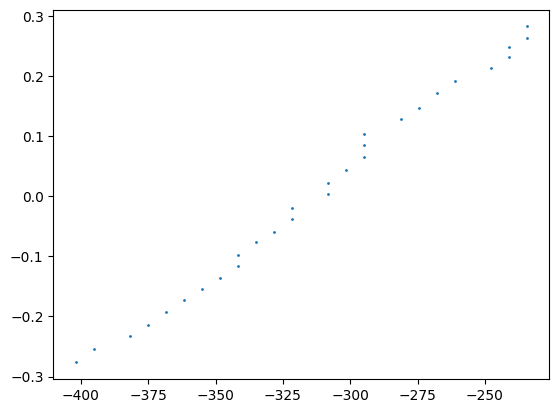

In [1262]:
#y_test= data_trans[:,2][(data_trans[:,2]>-0.75) * (data_trans[:,2]<0.75)]
data_trans_left = data_trans[half_hyst:]
indices_left = np.where((data_trans_left[:,2]>-0.3) * (data_trans_left[:,2]<0.3))[0]
lower_index_left = indices_left[[0, -1]][0]
upper_index_left = indices_left[[0, -1]][1]

data_fit_left = data_trans_left[lower_index_left:upper_index_left]
x_fit_left = data_fit_left[:,1] * 1000
y_fit_left = data_fit_left[:,2]
sx_left = data_fit_left[:,3] * 1000
sy_left = data_fit_left[:,4]
plt.scatter(x_fit_left, y_fit_left, s=1)
#plt.scatter(x_data_fit1, y_data_fit1, s=0.1)

In [1263]:
model_left = Model(model_f1)
data_left = RealData(x_fit_left, y_fit_left, sx=sx_left, sy=sy_left)
myodr = ODR(data_left, model_left, beta0=[0., 0.])

output = myodr.run()
output.pprint()


Beta: [0.0034589944 1.0864668949]
Beta Std Error: [0.0000572567 0.0172321928]
Beta Covariance: [[0.000004137  0.0012292312]
 [0.0012292312 0.374729986 ]]
Residual Variance: 0.0007924331635379338
Inverse Condition #: 0.000527354352045844
Reason(s) for Halting:
  Sum of squares convergence


In [1264]:
popt_left_FE, pcov_left_FE = output.beta, output.cov_beta

In [1265]:
y_predicted = model_f1(output.beta, x_fit_left)
residuals = y_fit_left - y_predicted

chi2 = sum((residuals / sy_left) ** 2)
n = len(y_fit_left) - len(output.beta)

red_Chi2 = chi2 / n
red_Chi2

1.977763177732538

In [1266]:
r, p = pearsonr(x_fit_left, y_fit_left)
r, p

(0.9963028006933865, 2.5297376218401096e-30)

### Fit right

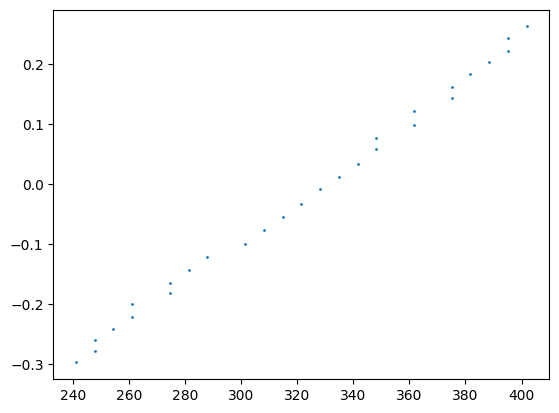

In [1267]:
data_trans_right = data_trans[:half_hyst]
indices_right = np.where((data_trans_right[:,2]>-0.3) * (data_trans_right[:,2]<0.3))[0]
lower_index_right = indices_right[[0, -1]][0]
upper_index_right = indices_right[[0, -1]][1]

data_fit_right = data_trans_right[lower_index_right:upper_index_right]
x_fit_right = data_fit_right[:,1] * 1000
y_fit_right = data_fit_right[:,2]
sx_right = data_fit_right[:,3] * 1000
sy_right = data_fit_right[:,4]
plt.scatter(x_fit_right, y_fit_right, s=1)

In [1268]:
model_right = Model(model_f1)
data_right = RealData(x_fit_right, y_fit_right, sx=sx_right, sy=sy_right)
myodr = ODR(data_right, model_right, beta0=[0., 0.])

output = myodr.run()
output.pprint()


Beta: [ 0.0033309418 -1.0920433124]
Beta Std Error: [0.000043141  0.0133624479]
Beta Covariance: [[ 0.000003853  -0.0011777528]
 [-0.0011777528  0.3696513236]]
Residual Variance: 0.00048303631388974276
Inverse Condition #: 0.0005201938498433595
Reason(s) for Halting:
  Sum of squares convergence


In [1269]:
popt_right_FE, pcov_right_FE = output.beta, output.cov_beta
popt_right_FE

array([ 0.0033309418, -1.0920433124])

In [1270]:
y_predicted = model_f1(output.beta, x_fit_right)
residuals = y_fit_right - y_predicted

chi2 = sum((residuals / sy_right) ** 2)
n = len(y_fit_right) - len(output.beta)

red_Chi2 = chi2 / n
red_Chi2

0.9322993940339944

In [1271]:
r, p = pearsonr(x_fit_right, y_fit_right)
r, p

(0.9978940141918613, 2.0113659435678048e-32)

### Korzitivfelstäreke H2

In [1272]:
H_left = - ufloat(popt_left_FE[1], pcov_left_FE[1, 1]) / ufloat(popt_left_FE[0], pcov_left_FE[0, 0])
H_right = - ufloat(popt_right_FE[1], pcov_right_FE[1, 1]) / ufloat(popt_right_FE[0], pcov_right_FE[0, 0])
H_FE = np.array([unumpy.nominal_values(H_left), unumpy.nominal_values(H_right)])
d_H_FE = np.array([unumpy.std_devs(H_left), unumpy.std_devs(H_right)])
print(H_left)
print(H_right)

(-3.1+/-1.1)e+02
(3.3+/-1.1)e+02


In [1273]:
H_avg = np.average(abs(H_FE), weights=1 / d_H_FE)
d_H_avg = np.sqrt(1 / sum(1 / d_H_FE))

In [1274]:
print("H ST37K: {} +/- {} A/m".format(H_avg, d_H_avg))

H ST37K: 320.8908786657054 +/- 7.404044238264994 A/m


## Ergebnisse Sättigungsinduktion

In [1275]:
file_path = '/Users/danielmiksch/Downloads/M2.csv'
data_m2 = pd.read_csv(file_path, sep=';')
#print(data_m9)

In [1276]:
np.set_printoptions(suppress=True, precision=10)
data_np = data_m2.to_numpy()
#data_np

In [1277]:
d_Flux = ufloat(0, (100 / 1000) * 0.025)
d_Inter = ufloat(0, 0.00122)
d_U = unumpy.std_devs(d_Inter + d_Flux) #[V]
N1, N2 = 605, 60
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = ufloat(0.2, 0.1) #[Ohm]
gamma= 0.1
F = 0.9
h = 0.03 #[m]

data_col1 = data_np[:, 1].copy()
data_col2 = data_np[:, 2].copy()

udata1 = unumpy.uarray(data_col1, d_U)
udata2 = unumpy.uarray(data_col2, d_U)
data_unp = np.column_stack((data_np[:,0], udata1, udata2))
# D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
# data_korr = data_np.copy()
# data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
# delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2

D_drift = (data_unp[-1, 2] - data_unp[0, 2]) / (data_unp[-1, 0] - data_unp[0, 0])
data_ukorr = data_unp.copy()
data_ukorr[:,2] = data_unp[:,2] - (data_unp[:,0] * D_drift)
delta_U = np.max(data_ukorr[:,2]) - (np.max(data_ukorr[:,2]) - np.min(data_ukorr[:,2])) / 2
d_U

array(0.002781798)

In [1278]:
data_usymm = data_ukorr.copy()
data_usymm[:,2] -= delta_U

In [1279]:
data_utrans = data_usymm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_utrans[:,1] = vec_H(data_utrans[:,1]) / 1000
data_utrans[:,2] = vec_B(data_utrans[:,2])
data_utrans

array([[0.0, -1.8014018548415796+/-0.9007700710910723,
        -1.3714259155473303+/-0.008942732540392632],
       [0.02, -1.8014018548415796+/-0.9007700710910723,
        -1.3705094659582062+/-0.013564448920593301],
       [0.04, -1.8014018548415796+/-0.9007700710910723,
        -1.3712782015542675+/-0.013562038773354601],
       ...,
       [63.6, -1.8014018548415796+/-0.9007700710910723,
        -1.371312518429282+/-0.011102369705315994],
       [63.62, -1.8054138856986879+/-0.9027759328787812,
        -1.3721164392105283+/-0.011103594597980927],
       [63.64, -1.8014018548415796+/-0.9007700710910723,
        -1.3714259155473303+/-0.008942732540392632]], dtype=object)

In [1280]:
x_udata = data_utrans[:,1]
y_udata = data_utrans[:,2]

In [1281]:
half_hyst = np.argmax(x_udata)

In [1282]:
nominal_values = unumpy.nominal_values(data_utrans)
std_devs = unumpy.std_devs(data_utrans)
data_trans = np.column_stack((nominal_values, std_devs[:,1:]))

### Fit upper

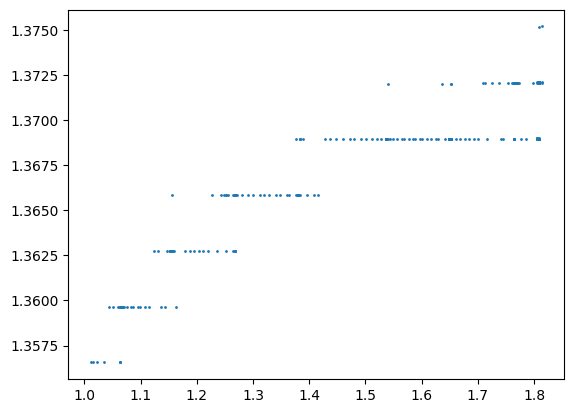

In [1283]:
data_trans_upper = data_trans[half_hyst:]
indices_upper = np.where((data_trans_upper[:,1]>1))[0]
lower_index_upper = indices_upper[[0, -1]][0]
upper_index_upper = indices_upper[[0, -1]][1]

data_fit_upper = data_trans_upper[lower_index_upper:upper_index_upper]
x_fit_upper = data_fit_upper[:,1]
y_fit_upper = data_fit_upper[:,2]
sx_upper = data_fit_upper[:,3]
sy_upper = data_fit_upper[:,4]
plt.scatter(x_fit_upper, y_fit_upper, s=1)

# popt_upper_FE, pcov_upper_FE = curve_fit(model_f, x_fit_upper, y_fit_upper, p0=[0, 0])
# print(popt_upper_FE)
# pcov_upper_FE


In [1284]:
model = Model(model_f1)
data = RealData(x_fit_upper, y_fit_upper, sx=sx_upper, sy=sy_upper)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_upper_FE, pcov_upper_FE = output.beta, output.cov_beta

Beta: [0.0159026838 1.3434473713]
Beta Std Error: [0.0002006987 0.000321483 ]
Beta Covariance: [[ 0.000006719  -0.0000106005]
 [-0.0000106005  0.0000172397]]
Residual Variance: 0.0059949585289773835
Inverse Condition #: 0.07098624283882608
Reason(s) for Halting:
  Sum of squares convergence


### Fit lower

In [1285]:
data_trans_lower = data_trans[:half_hyst]
indices_lower = np.where((data_trans_lower[:,1]<-1) )[0]
lower_index_lower = indices_lower[[0, -1]][0]
upper_index_lower = indices_lower[[0, -1]][1]

data_fit_lower = data_trans_lower[lower_index_lower:upper_index_lower]
x_fit_lower = data_fit_lower[:,1]
y_fit_lower = data_fit_lower[:,2]
sx_lower = data_fit_lower[:,3]
sy_lower = data_fit_lower[:,4]


In [1286]:
model = Model(model_f1)
data = RealData(x_fit_lower, y_fit_lower, sx=sx_lower, sy=sy_lower)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_lower_FE, pcov_lower_FE = output.beta, output.cov_beta

Beta: [ 0.0138624236 -1.346911969 ]
Beta Std Error: [0.0003111842 0.0004772401]
Beta Covariance: [[0.0000166863 0.0000252268]
 [0.0000252268 0.0000392463]]
Residual Variance: 0.0058032976935631225
Inverse Condition #: 0.07081986872638399
Reason(s) for Halting:
  Sum of squares convergence


In [1287]:
B_perm = weighted_avg(popt_upper_FE, popt_lower_FE, pcov_upper_FE, pcov_lower_FE, 'a')
print("B Perenorm: {} +/- {} mT".format(B_perm[0] * 1000, B_perm[1] * 1000))
# popt_upper_FE

B Perenorm: 1344.5047766828632 +/- 3.4609385869759586 mT


## Ergebnisse Holz

In [1288]:
file_path = '/Users/danielmiksch/Downloads/M5.csv'
data_m5 = pd.read_csv(file_path, sep=';')
np.set_printoptions(suppress=True, precision=10)
data_np = data_m5.to_numpy()

In [1289]:
d_Flux = ufloat(0, (2 / 1000) * 0.025)
d_Inter = ufloat(0, 0.00122)
d_U = unumpy.std_devs(d_Inter + d_Flux) #[V]
N1, N2 = 1010, 250
d_a, d_i = 0.26, 0.22 #[m]
d = (d_a + d_i) / 2
R = ufloat(67.6, 0.1) #[Ohm]
gamma= (1 / 500)
F = 1
h = 0.03 #[m]

data_col1 = data_np[:, 1].copy()
data_col2 = data_np[:, 2].copy()

udata1 = unumpy.uarray(data_col1, d_U)
udata2 = unumpy.uarray(data_col2, d_U)
data_unp = np.column_stack((data_np[:,0], udata1, udata2))
# D_drift = (data_np[-1, 2] - data_np[0, 2]) / (data_np[-1, 0] - data_np[0, 0])
# data_korr = data_np.copy()
# data_korr[:,2] = data_np[:,2] - (data_np[:,0] * D_drift)
# delta_U = np.max(data_korr[:,2]) - (np.max(data_korr[:,2]) - np.min(data_korr[:,2])) / 2

D_drift = (data_unp[-1, 2] - data_unp[0, 2]) / (data_unp[-1, 0] - data_unp[0, 0])
data_ukorr = data_unp.copy()

data_ukorr[:,2] = data_unp[:,2] - (data_unp[:,0] * D_drift)

delta_U = np.max(data_ukorr[:,2]) - (np.max(data_ukorr[:,2]) - np.min(data_ukorr[:,2])) / 2
data_ukorr

array([[0.0, -6.855+/-0.0012210241602851272,
        0.053+/-0.0012210241602851272],
       [0.02, -6.855+/-0.0012210241602851272,
        0.05399009900990099+/-0.0012210266030687257],
       [0.04, -6.855+/-0.0012210241602851272,
        0.05298019801980198+/-0.001221033931390199],
       ...,
       [14.1, -7.006+/-0.0012210241602851272,
        0.05301980198019802+/-0.002110889316382841],
       [14.12, -7.007+/-0.0012210241602851272,
        0.05200990099009901+/-0.0021128821281860607],
       [14.14, -7.006+/-0.0012210241602851272,
        0.053+/-0.0012210241602851272]], dtype=object)

In [1290]:
data_usymm = data_ukorr.copy()
data_usymm[:,2] -= delta_U

In [1291]:
data_utrans = data_usymm.copy()
vec_H = np.vectorize(H)
vec_B = np.vectorize(B)
data_utrans[:,1] = vec_H(data_utrans[:,1])
data_utrans[:,2] = vec_B(data_utrans[:,2])
data_utrans

array([[0.0, -45913.216926828834+/-22956.609920118393,
        -0.0003163696369636963+/-1.6809532754507987e-05],
       [0.02, -45913.216926828834+/-22956.609920118393,
        -0.0003031683168316831+/-2.535616959612009e-05],
       [0.04, -45913.216926828834+/-22956.609920118393,
        -0.0003166336633663366+/-2.5336064826118722e-05],
       ...,
       [14.1, -46924.58027561821+/-23462.291563116807,
        -0.0003161056105610561+/-2.1220549594906162e-05],
       [14.12, -46931.27804613999+/-23465.640448174283,
        -0.00032957095709570955+/-2.1231716268038236e-05],
       [14.14, -46924.58027561821+/-23462.291563116807,
        -0.0003163696369636963+/-1.6809532754507987e-05]], dtype=object)

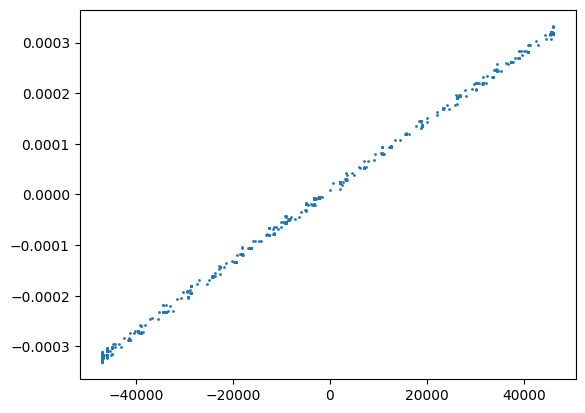

In [1292]:
x_udata = data_utrans[:,1]
y_udata = data_utrans[:,2]
plt.scatter(unumpy.nominal_values(x_udata), unumpy.nominal_values(y_udata), s=1)

In [1293]:
nominal_values = unumpy.nominal_values(data_utrans)
std_devs = unumpy.std_devs(data_utrans)
data_trans = np.column_stack((nominal_values, std_devs[:,1:]))

In [1294]:
x_fit_wood = data_trans[:,1]
y_fit_wood = data_trans[:,2]
sx_wood = data_trans[:,3]
sy_wood = data_trans[:,4]

Beta: [0.0000000069 0.0000086855]
Beta Std Error: [0.           0.0000001754]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.009450288987745853
Inverse Condition #: 8.032650891557868e-05
Reason(s) for Halting:
  Sum of squares convergence
[[0. 0.]
 [0. 0.]]


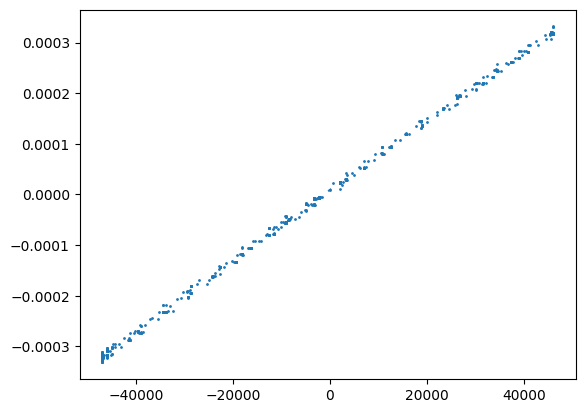

In [1295]:
model = Model(model_f1)
data = RealData(x_fit_wood, y_fit_wood, sx=sx_wood, sy=sy_wood)
myodr = ODR(data, model, beta0=[0., 0.])

output = myodr.run()
output.pprint()

popt_holz, pcov_holz = curve_fit(model_f, x_fit_wood, y_fit_wood, sigma=sy_wood, absolute_sigma=True)
print(pcov_holz)

popt_wood, pcov_wood = output.beta, output.sd_beta


x = np.linspace(-150, 150, 1000)
plt.scatter(x_fit_wood, y_fit_wood, s=1)
plt.plot(x, model_f(x, popt_wood[0], popt_wood[1]))

In [1296]:
mu_holz = ufloat(popt_wood[0], pcov_wood[0]) / mu_0
mu_holz
print("mu holz = {} +/- {}".format(unumpy.nominal_values(mu_holz), unumpy.std_devs(mu_holz)))

mu holz = 0.0055117650288806184 +/- 1.1303256318118387e-05


In [1297]:
y_predicted = model_f1(output.beta, x_fit_wood)
residuals = y_fit_wood - y_predicted

chi2 = sum((residuals / sy_wood) ** 2)
n = len(y_fit_wood) - len(output.beta)

red_Chi2 = chi2 / n
red_Chi2

0.08514978260968455

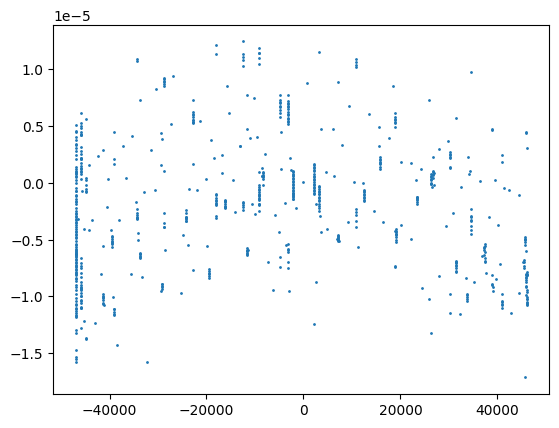

In [1298]:
plt.scatter(x_fit_wood, residuals, s=1)

In [1299]:
print("{} data points > 0".format(np.sum(residuals > 0)))
print("{} data points < 0".format(np.sum(residuals < 0)))

247 data points > 0
461 data points < 0


In [1300]:
r, p = pearsonr(x_fit_wood, y_fit_wood)
r, p

(0.9996350610345487, 0.0)

## Export Plots

In [1301]:
def save_all_plots(should_save=True, save_path='./'):
    if should_save:
        for idx, item in enumerate(all_plots, 1):
            fig = item[0] if isinstance(item, tuple) else item
            fig.savefig(f"{save_path}C39_{idx}.pdf", dpi=300, format='pdf')

In [1302]:
save_all_plots(True, "/Users/danielmiksch/Downloads/")